VORTEX-SE Sounding Cleanup
==========================

TODO
----
- Add town name parameters to sounding class.
- Write out data in common file format - fill out last method in class.


Information about map: EDT                 
==================================

Map name (internal)     : EDT000
Sounding set (internal) : 0
RS-Number               : J1843008
Data record length      : 40 bytes
Number of data records  : 789
Max filemap size        : 789 bytes
Data header size        : 12504 bytes
Free space in map       : -43275 bytes (107373100 records)
Status flag (not used)  : 1


   Record name:    Unit:           Data type:          Divisor: Offset:
   ---------------------------------------------------------------------
    time            sec             float (4)          1        0       
    Pscl            ln              short (2)          1        0       
    T               K               short (2)          10       0       
    RH              %               short (2)          1        0       
    v               m/s             short (2)          -100     0       
    u               m/s             short (2)          -100     0       
    Height          m               short (2)          1        30000   
    P               hPa             short (2)          10       0       
    TD              K               short (2)          10       0       
    MR              g/kg            short (2)          100      0       
    DD              dgr             short (2)          1        0       
    FF              m/s             short (2)          10       0       
    AZ              dgr             short (2)          1        0       
    Range           m               short (2)          0.01     0       
    Lon             dgr             short (2)          100      0       
    Lat             dgr             short (2)          100      0       
    SpuKey          bitfield        unsigned short (2) 1        0       
    UsrKey          bitfield        unsigned short (2) 1        0       
    RadarH          m               short (2)          1        30000   


In [1]:
import os
import glob
import numpy as np
import pandas
from collections import defaultdict

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

/Users/ebruning/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
from metpy.units import units
from metpy.calc import dewpoint_rh, get_wind_components, get_wind_dir, get_wind_speed, mixing_ratio, saturation_vapor_pressure
# from scipy.constants import K2C
from metpy.plots import SkewT, Hodograph


In [4]:
tsv_dtype = [('time','f4'), ('Pscl','f4'), 
                                       ('T','f4'), ('RH','f4'),
                                       ('v','f4'), ('u','f4'),
                                       ('Height','f4'), ('P','f4'), 
                                       ('TD','f4'), ('MR','f4'),
                                       ('wdir','f4'), ('wspd','f4'),
                                       ('AZ','f4'), ('Range','f4'),
                                       ('Lon','f4'), ('Lat','f4'),
                                       ('SpuKey','f4'), ('UsrKey','f4'),
                                       ('RadarH','f4'),
                                       ]
def read_tsv(filename, skip=0):
    data = np.loadtxt(filename, dtype=tsv_dtype, skiprows=skip)
    return data
    

In [5]:
header_template = """# VORTEX-SE TTU Radiosonde Data
# %Y-%m-%d, %H%M UTC, {0}
# latitude (deg), longitude (deg), UTC time from launch (HHMMSS), height (m AGL), pressure (mb), temp (deg C), mixing ratio (g/kg), wind speed (m/s), wind direction (deg)
"""


from datetime import datetime, timedelta
import os
class SoundingPostProcessor(object):
    def __init__(self, filename, dateparser='TTUBOLT_%y%m%d_%H%M%S.sounding.tsv', 
                 start_latlon=None, location='Unknown Location'):
        """ Sounding post-processing helper class. 
        
            Arguments: 
            *filename* path to a Vaisala RS-92 .tsv file on disk
            *dateparser* used by strp    
            
            Filtered data are available from 
            self.T, self.p, self.RH, self.Td, self.uv

            To filter data, set a key in self.filters that matches one of 
            the filtered data attributes listed above. Matching values will be set to
            NaN when retrieved through the filtered data attributes.
            
            Helper functions for visualizing data:
            --------------------------------------
            plot_hodo: plots hodograph; returns figure instance
            plot_skewt: plots Skew-T; returns figure instance
            print_raw_data: returns a pandas dataframe. Can be sliced by passing start,stop,step.
        
        """
        #import appropriate .tsv for plotting, downloaded directly from sounding laptop
        self.launch = datetime.strptime(os.path.split(filename)[-1], dateparser)
        self.location = location
        print self._file_header()
#         print("Launch at {0}".format(self.launch))
        self.filename = filename
        self.data=read_tsv(filename,skip=40)
        self.filters = defaultdict(lambda:np.zeros(self.data.shape, dtype=bool))
        self.start_latlon = start_latlon
#         pathparts = os.path.split(filename)
    

    def _file_header(self):
        header_withlocation = header_template.format(self.location)
        header = self.launch.strftime(header_withlocation)
        return header
    
    @property
    def utctime(self):
        """UTC time to the nearest second"""
        tsec = self.data['time']
        tutc = [self.launch + timedelta(0,int(tseci)) for tseci in tsec]     
        tutcout = pandas.DataFrame(pandas.to_datetime(tutc), columns=('time',))
        tutcout.set_index(['time'],inplace=True)
        return tutcout
    
    @property
    def height(self):
        "height in meters"
        filt = self.filters['height']
        z = self.data['Height'] * units.meter
        filt |= ((z < 0*units.meter) | (z > 30*units.kilometer))
        z[filt] = np.nan
        return z
    
    @property
    def p(self):
        " pressure in millibars "
        filt = self.filters['p']
        Pmb = self.data['P']*units.millibar
        Pmb[filt] = np.nan
        return Pmb
    
    @property
    def T(self):
        "temperature in deg C"
        filt = self.filters['T']
        TC = (self.data['T']*units.kelvin).to(units.celsius)
#         TC = K2C(self.data['T'])
        TC[filt] = np.nan
        return TC

    @property
    def RH(self):
        filt = self.filters['RH']
        RHpct = self.data['RH']*units.percent #/100.0
        RHpct[filt] = np.nan
        return RHpct
    
    @property
    def Td(self):
        "dewpoint temperature in deg c"
        filt = self.filters['Td']
        TdC = (self.data['TD']*units.kelvin).to(units.celsius)
#         TdC = K2C(self.data['TD']) #dewpoint_rh(T,RH)
        TdC[filt] = np.nan
        return TdC
    
    @property
    def mixing_ratio(self):
        return mixing_ratio(saturation_vapor_pressure(self.Td), self.p)
        
    @property
    def uv(self):
        "wind speed and direction in knots"
        filt = self.filters['uv']
        u, v = get_wind_components(self.data['wspd'], self.data['wdir']*units.deg)
        u, v = (u*units('m/s')).to(units.knot), (v*units('m/s')).to(units.knot)
        
        spd = np.sqrt(u*u+v*v)
        wind_mask = spd > 200*units.knot
        filt |= wind_mask
        
        u[filt] = np.nan
        v[filt] = np.nan
        return (u,v)
    
    @property
    def azran(self):
        filt = self.filters['azran']
        az, ran = self.data['AZ']*units.degree, self.data['Range']*units.degree
        filt |= (az < 0.0) | (az > 360.0)
        filt |= (ran.astype(int) == -32768)
        
        az[filt] = np.nan
        ran[filt] = np.nan
        return (az,ran)
    
    @property
    def latlon(self):
        filt = self.filters['latlon']
        lat, lon = self.data['Lat']*units.degree, self.data['Lon']*units.degree
        
        if self.start_latlon is not None:
            start_lat, start_lon = self.start_latlon
            if ((np.abs(np.median(lat[0:10]) - start_lat) > 0.01) |
                (np.abs(np.median(lon[0:10]) - start_lon) > 0.01)):
#                      filt |= np.ones_like(lat, dtype=bool)
                print("Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.")
                lat, lon = self.recalculate_latlon()
                



        filt |= (np.abs(lat) > 90.0) | (np.abs(lon) > 180.0) 
        lat[filt] = np.nan
        lon[filt] = np.nan
        
        return (lat, lon)
    
    def recalculate_latlon(self):
        """ Using the starting location specified in self.start_latlon, use azimuth and range
            to calculate a new track.
        """
        ctr_lat, ctr_lon = self.start_latlon
        from lmatools.coordinateSystems import MapProjection, GeographicSystem
        mapSys = MapProjection(projection='aeqd', ctrLat=ctr_lat, ctrLon=ctr_lon, lat_ts=ctr_lat, 
                                lon_0=ctr_lon, lat_0=ctr_lat, lat_1=ctr_lat, ellipse='WGS84', datum='WGS84')
        geoSys = GeographicSystem()

        az, ran = self.azran #np.radians(self.data['AZ']), self.data['Range']
        az = np.radians(az)
        lon, lat, alt = geoSys.fromECEF(*mapSys.toECEF(ran*np.sin(az), ran*np.cos(az), np.zeros_like(az)))
        return lat, lon

    
    def plot_track(self):
        traj = plt.figure(figsize=(12,6))
        ax = traj.add_subplot(121)
        lat,lon = self.latlon
        ax.plot(lon, lat)
        ax.plot(self.start_latlon[1], self.start_latlon[0], 'ro')
        ax.set_title(self.filename)
        ax.set_xlabel('Longitude (deg)')
        ax.set_ylabel('Latitude (deg)')
        
        axz = traj.add_subplot(122)
        axz.plot_date(self.utctime.index, self.height.to('kilometer'), '-')
        axz.set_title(self.filename)
        axz.set_xlabel('Time (UTC)')
        axz.set_ylabel('Altitude (km)')
        return traj
        
    def plot_hodo(self):
        """plot the hodograph"""
        hodo = plt.figure(figsize=(8,8))
        hodo_ax = hodo.add_subplot(111)
        h = Hodograph(hodo_ax, component_range=100.)
        h.add_grid(increment=20)
        
#         hodo_mask = (self.p > 200*units.millibar) &(self.p<891.0002441*units.millibar)
        u, v = self.uv
        h.plot(u,v)
#         h.plot(u[hodo_mask],v[hodo_mask])
        
        hodo_ax.axis((-40,100, -40,100))
        hodo_ax.set_xlabel('u wind (kt)')
        hodo_ax.set_ylabel('v wind (kt)')
        #change title depending on location and time of launch
        title = self.filename
        hodo_ax.set_title(title)
        return hodo
    
    def plot_skewt(self, barbs_every=50):
        """plot the skew-t"""
        skewt = SkewT(plt.figure(figsize=(12,12)))
        skewt.plot(self.p, self.T, 'b')
        skewt.plot(self.p, self.Td, 'g')
        barb_mask = slice(None,None,barbs_every)
        u, v = self.uv
        skewt.plot_barbs(self.p[barb_mask],u[barb_mask],v[barb_mask])
        skewt.plot_dry_adiabats()
        skewt.plot_moist_adiabats()
        skewt.plot_mixing_lines()
        #change title depending on location and time of launch
        title = self.filename #'10 July 2015, 2300 UTC - 3 W Shallowater'
        skewt.ax.set_title(title)
        skewt.ax.axis((-40, 40, 1000, 100))
        skewt.ax.set_xlabel(u'Temperature (°C)')
        skewt.ax.set_ylabel(u'Pressure (mb)')
        return skewt
    
    def print_raw_data(self, start=None, end=None, step=1):
        sl = slice(start, end, step)
        d = self.data
        return pandas.DataFrame(d[sl])
    
    
    def print_filtered_data(self, start=None, end=None, step=1):
        sl = slice(start, end, step)
        d = self.assemble_filtered_data()
        return d[sl]


    def assemble_filtered_data(self):
        """ Assemble filtered data into a pandas DataFrame """
        #latitude (deg), longitude (deg), UTC time from launch (HHMMSS), height (m AGL), pressure (mb), temp (deg C), mixing ratio (g/kg), wind speed (m/s), wind direction (deg)

        lat, lon = self.latlon
        tutc = self.utctime
        z = self.height.to('meters')
        z -= np.nanmin(z)*units.meters
        p = self.p.to('millibars')
        T = self.T.to('celsius')
        mixr = self.mixing_ratio.to('g/kg')
        u, v = self.uv
        wdir, wspd= get_wind_dir(u, v).to(units.degree), get_wind_speed(u, v).to('m/s')
        
        dataout = pandas.DataFrame({
                'lat':lat, 'lon':lon, 'time':tutc.index,
                'height':z, 'p':p, 'T':T, 'mixr':mixr, 'wspd':wspd, 'wdir':wdir
            }
        )
        return dataout
        
    def save_filtered(self, filename):
        """ Apply filters and save a new CSV-formatted data file to filename"""
        dataout = self.assemble_filtered_data()
        header_data = self._file_header()
        outfile = open(filename, 'w')
        outfile.write(header_data)
        dataout.to_csv(outfile, date_format='%H%M%S',
                       columns=('lat', 'lon', 'time',
                                'height', 'p', 'T', 'mixr', 'wspd', 'wdir'),
                       header=False, #self._file_header(),
                       index=False,
                       float_format=' %10.6f')
        outfile.close()

In [6]:
orig_paths = glob.glob('../*.tsv')
for pth in orig_paths: print(pth)

../TTUBOLT_160218_173905.sounding.tsv
../TTUBOLT_160314_060223.sounding.tsv
../TTUBOLT_160314_080125.sounding.tsv
../TTUBOLT_160314_090209.sounding.tsv
../TTUBOLT_160324_162758.sounding.tsv
../TTUBOLT_160324_213159.sounding.tsv
../TTUBOLT_160331_200311.sounding.tsv
../TTUBOLT_160331_220853.sounding.tsv
../TTUBOLT_160331_233133.sounding.tsv
../TTUBOLT_160401_010108.sounding.tsv
../TTUBOLT_160401_020455.sounding.tsv
../TTUBOLT_160427_200037.sounding.tsv
../TTUBOLT_160427_230601.sounding.tsv
../TTUBOLT_160429_211028.sounding.tsv
../TTUBOLT_160429_225500.sounding.tsv
../TTUBOLT_160430_160552.sounding.tsv
../TTUBOLT_160430_180023.sounding.tsv
../TTUBOLT_160430_200014.sounding.tsv
../TTUBOLT_160430_214048.sounding.tsv
../TTUBOLT_160501_163014.sounding.tsv
../TTUBOLT_160501_173014.sounding.tsv
../TTUBOLT_160501_184237.sounding.tsv
../TTUBOLT_160501_193016.sounding.tsv
../TTUBOLT_160501_203018.sounding.tsv


In [7]:
mar14_06 = '../TTUBOLT_160314_060223.sounding.tsv'
mar14_08 = '../TTUBOLT_160314_080125.sounding.tsv'
mar14_09 = '../TTUBOLT_160314_090209.sounding.tsv'
mar24_16 = '../TTUBOLT_160324_162758.sounding.tsv'
mar24_21 = '../TTUBOLT_160324_213159.sounding.tsv'
mar31_20 = '../TTUBOLT_160331_200311.sounding.tsv'
mar31_22 = '../TTUBOLT_160331_220853.sounding.tsv'
mar31_23 = '../TTUBOLT_160331_233133.sounding.tsv'
apr01_01 = '../TTUBOLT_160401_010108.sounding.tsv'
apr01_02 = '../TTUBOLT_160401_020455.sounding.tsv'
apr27_20 = '../TTUBOLT_160427_200037.sounding.tsv'
apr27_23 = '../TTUBOLT_160427_230601.sounding.tsv'
apr29_21 = '../TTUBOLT_160429_211028.sounding.tsv'
apr29_23 = '../TTUBOLT_160429_225500.sounding.tsv'
apr30_16 = '../TTUBOLT_160430_160552.sounding.tsv'
apr30_18 = '../TTUBOLT_160430_180023.sounding.tsv'
apr30_20 = '../TTUBOLT_160430_200014.sounding.tsv'
apr30_21 = '../TTUBOLT_160430_214048.sounding.tsv'
may01_16 = '../TTUBOLT_160501_163014.sounding.tsv'
may01_17 = '../TTUBOLT_160501_173014.sounding.tsv'
may01_18 = '../TTUBOLT_160501_184237.sounding.tsv'
may01_19 = '../TTUBOLT_160501_193016.sounding.tsv'
may01_20 = '../TTUBOLT_160501_203018.sounding.tsv'

## March 13-14 2016

DARTS at Muscle Shoals Airport, just outside south fence gate
- 34.74022972, -87.61192000 146.94

Soundings at Lexington AL Church of Christ, with PIPS DSD
- 34.9612 -87.37034

Launches
- 0602 UTC
- 0801 UTC

# VORTEX-SE TTU Radiosonde Data
# 2016-03-14, 0602 UTC, Lexington, AL
# latitude (deg), longitude (deg), UTC time from launch (HHMMSS), height (m AGL), pressure (mb), temp (deg C), mixing ratio (g/kg), wind speed (m/s), wind direction (deg)

Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.
Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.


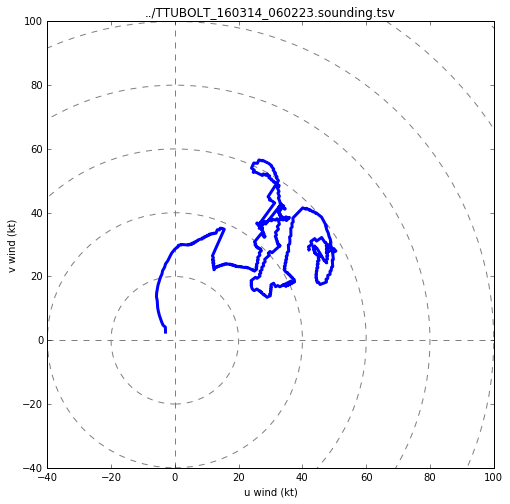

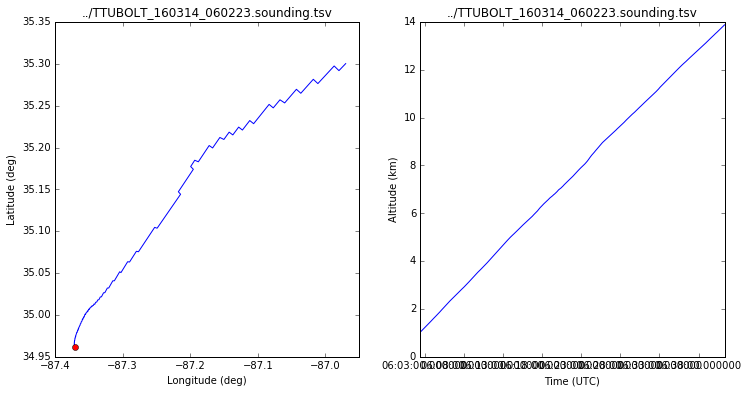

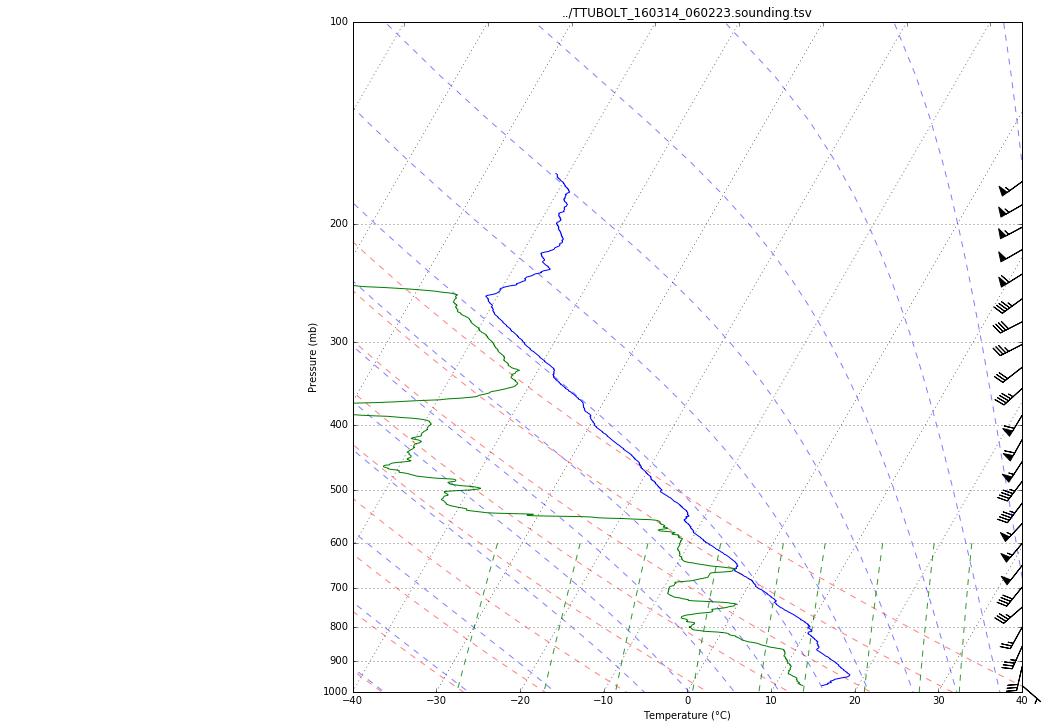

In [8]:
snd = SoundingPostProcessor(mar14_06, start_latlon=(34.9612, -87.37034), location='Lexington, AL')
snd.plot_hodo()
snd.plot_track()
snd.plot_skewt()
# print(snd.print_raw_data(0, 10))
# print(snd.print_filtered_data())
outfile = snd.launch.strftime("%Y%m%d_%H%MZ_TTU_{0}.txt".format(snd.location.replace(" ", "").replace(",", "")))
snd.save_filtered(outfile)

# VORTEX-SE TTU Radiosonde Data
# 2016-03-14, 0801 UTC, Lexington, AL
# latitude (deg), longitude (deg), UTC time from launch (HHMMSS), height (m AGL), pressure (mb), temp (deg C), mixing ratio (g/kg), wind speed (m/s), wind direction (deg)

Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.
Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.


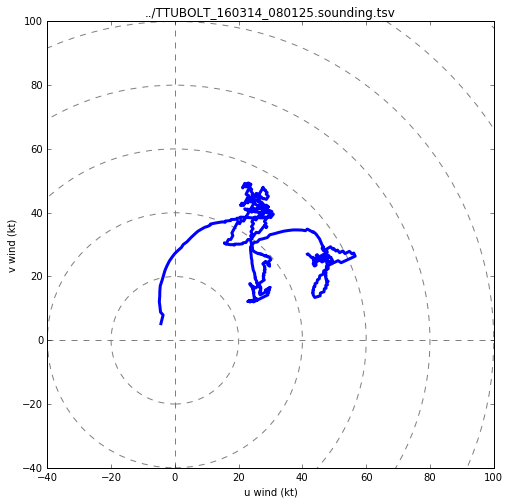

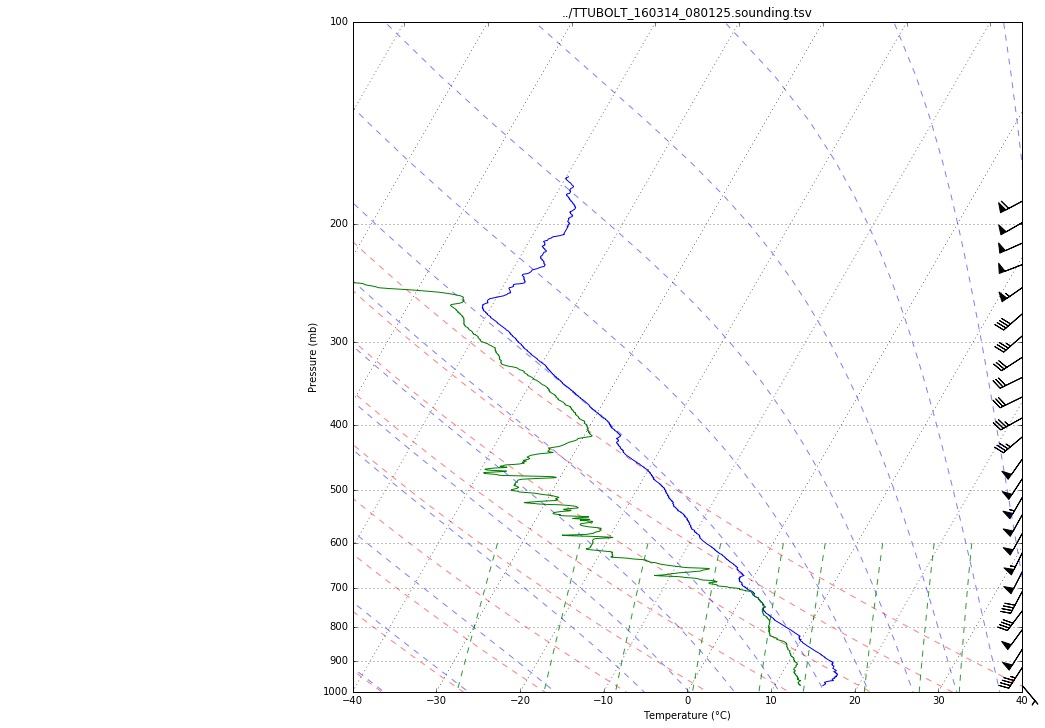

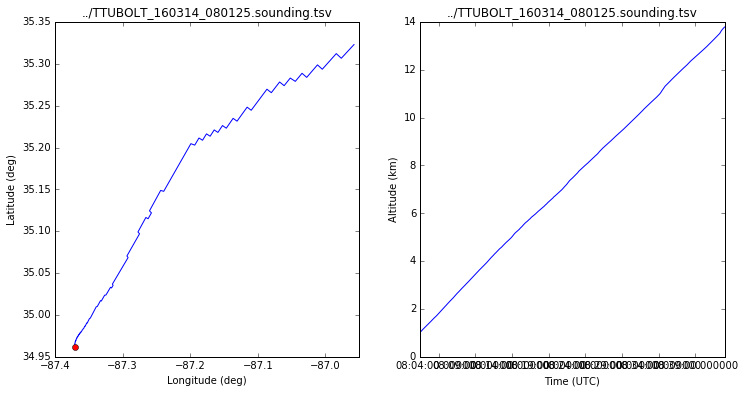

In [9]:
snd = SoundingPostProcessor(mar14_08, start_latlon=(34.9612, -87.37034), location='Lexington, AL')
snd.plot_hodo()
snd.plot_skewt()
snd.plot_track()
# snd.print_raw_data(0, 20)

outfile = snd.launch.strftime("%Y%m%d_%H%MZ_TTU_{0}.txt".format(snd.location.replace(" ", "").replace(",", "")))
snd.save_filtered(outfile)

# VORTEX-SE TTU Radiosonde Data
# 2016-03-14, 0902 UTC, Lexington, AL
# latitude (deg), longitude (deg), UTC time from launch (HHMMSS), height (m AGL), pressure (mb), temp (deg C), mixing ratio (g/kg), wind speed (m/s), wind direction (deg)

Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.
Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.


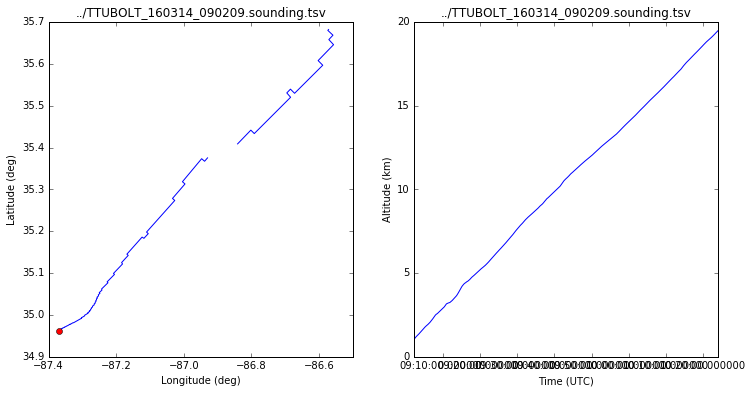

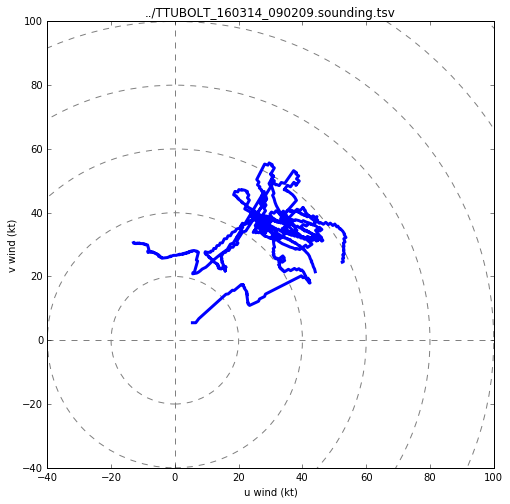

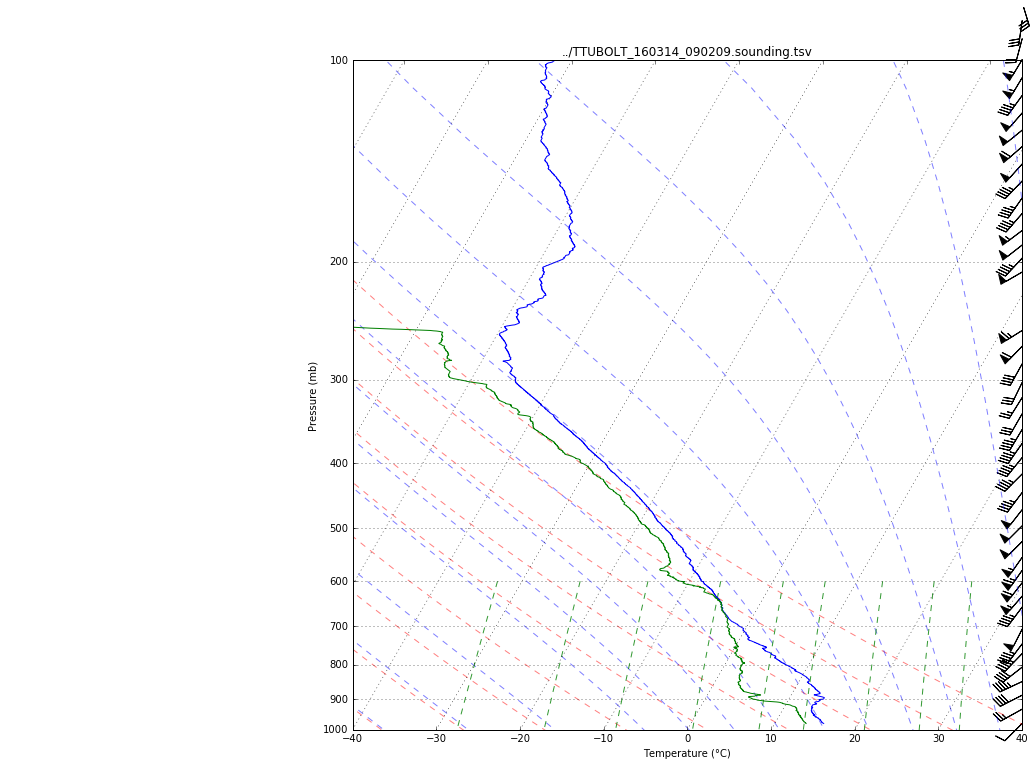

In [10]:
snd = SoundingPostProcessor(mar14_09, start_latlon=(34.9612, -87.37034), location='Lexington, AL')
# u, v = snd.uv
# spd = np.sqrt(u*u+v*v)
# wind_mask = spd > (200*units.knot)
# snd.filters['uv'] = wind_mask

snd.plot_track()
snd.plot_hodo()
snd.plot_skewt()
# snd.print_raw_data(0, 20)

outfile = snd.launch.strftime("%Y%m%d_%H%MZ_TTU_{0}.txt".format(snd.location.replace(" ", "").replace(",", "")))
snd.save_filtered(outfile)

## March 24 2016

DARTS at Moulton Rec Center. Talked to facility mananger, aka Bird.
- 34.47935 -87.30890
Deployed ~1355 UTC, undeployed 2230 UTC

Sounding at Danville Middle School
- 34.417262, -87.092507, 634 feet elevation
- Launch at 1625 UTC

Sounding north of Hartselle, AL
- 34.34202, -86.93706
- Launch at 2131 UTC

# VORTEX-SE TTU Radiosonde Data
# 2016-03-24, 1627 UTC, Danville, AL
# latitude (deg), longitude (deg), UTC time from launch (HHMMSS), height (m AGL), pressure (mb), temp (deg C), mixing ratio (g/kg), wind speed (m/s), wind direction (deg)

Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.
Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.


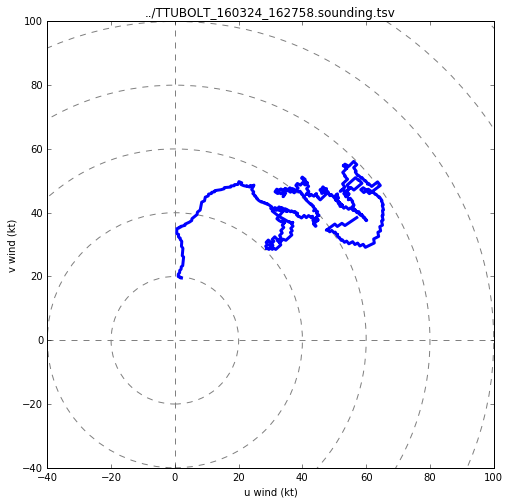

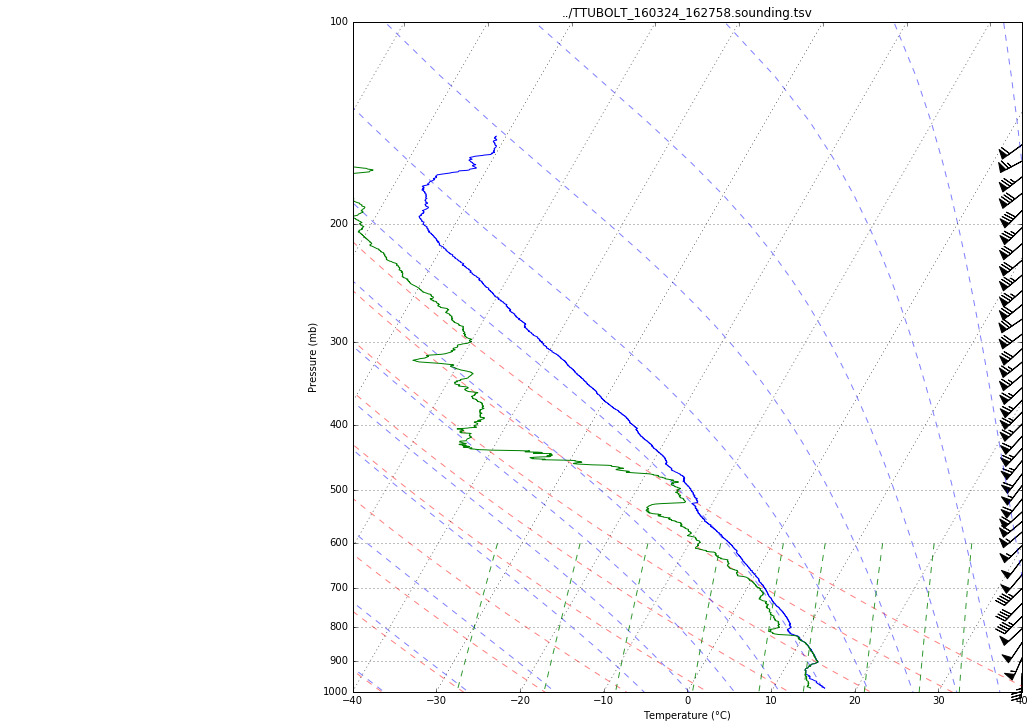

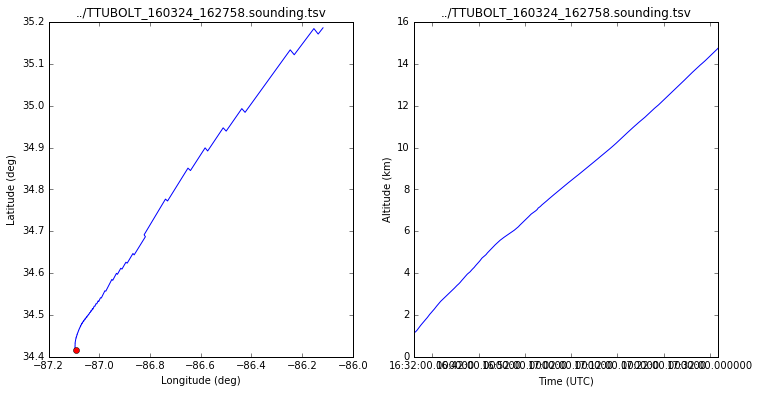

In [11]:
snd = SoundingPostProcessor(mar24_16, start_latlon=(34.417262, -87.092507), location="Danville, AL")
uv_filt = snd.filters['uv']
uv_filt[[0,1,2,3,4]] = True
snd.filters['uv'] = uv_filt

snd.plot_hodo()
snd.plot_skewt()
snd.plot_track()
# snd.print_raw_data(0, 20)

outfile = snd.launch.strftime("%Y%m%d_%H%MZ_TTU_{0}.txt".format(snd.location.replace(" ", "").replace(",", "")))
snd.save_filtered(outfile)


# VORTEX-SE TTU Radiosonde Data
# 2016-03-24, 2131 UTC, Hartselle, AL
# latitude (deg), longitude (deg), UTC time from launch (HHMMSS), height (m AGL), pressure (mb), temp (deg C), mixing ratio (g/kg), wind speed (m/s), wind direction (deg)

Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.
Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.


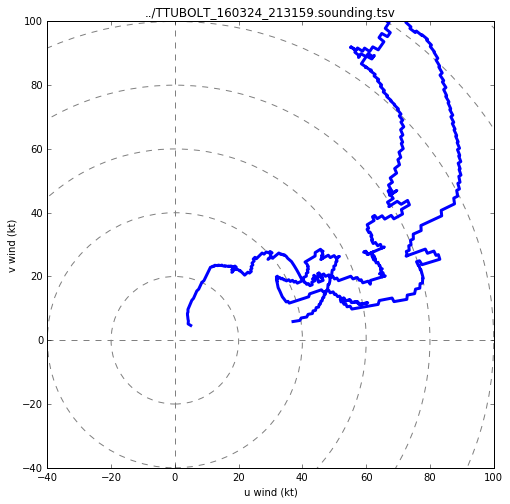

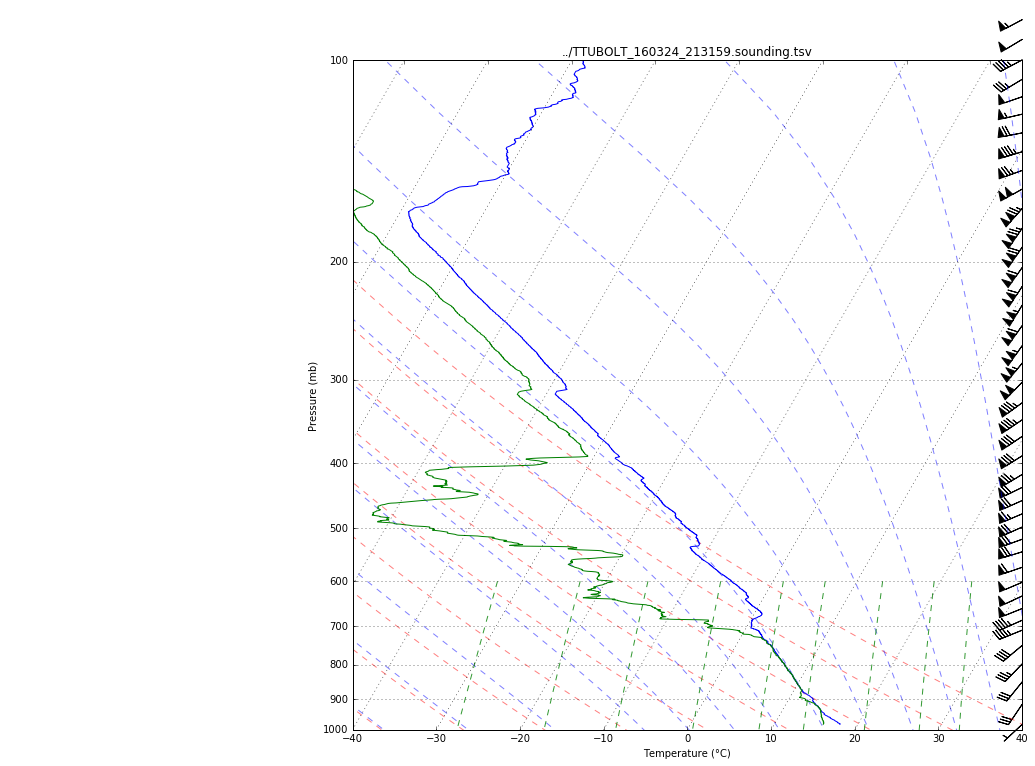

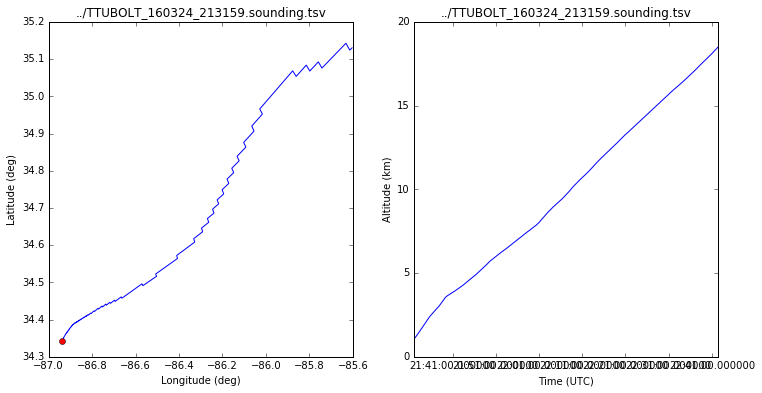

In [12]:
snd = SoundingPostProcessor(mar24_21, start_latlon=(34.34202, -86.93706), location="Hartselle, AL")
snd.plot_hodo()
snd.plot_skewt()
snd.plot_track()
# snd.print_raw_data(0, 20)
outfile = snd.launch.strftime("%Y%m%d_%H%MZ_TTU_{0}.txt".format(snd.location.replace(" ", "").replace(",", "")))
snd.save_filtered(outfile)

## March 31 2016

DARTS at Muscle Shoals Airport. 
Deployed ~16 UTC

Purdue and TTU teams ferried together througout the day.

Sounding at Russelville, AL
- 34.484175, -87.714565 (BOLT log, parking lot on south side of ball fields)
- Launches at 
    - 2002 UTC
    - 2208 UTC
    - 2331 UTC

West Moulton, AL
- 34.484003, -87.434229 
- Launch of Purdue sonde at 0001

Hartselle, AL
34.447600, -86.898953 (from ops ctr log; Cracker Barrel parking lot)
- Launch at 0101 UTC
    
Sounding NW of Cullman, exit 310.
- 34.208442, -86.881505 (from ops ctr log)
- Launch at 0205 UTC

# VORTEX-SE TTU Radiosonde Data
# 2016-03-31, 2003 UTC, Russelville, AL
# latitude (deg), longitude (deg), UTC time from launch (HHMMSS), height (m AGL), pressure (mb), temp (deg C), mixing ratio (g/kg), wind speed (m/s), wind direction (deg)

Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.
Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.


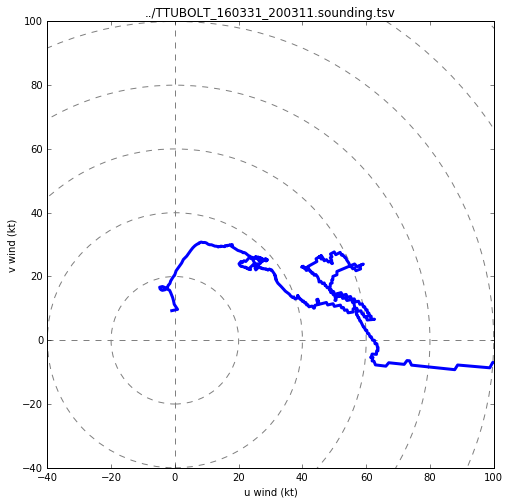

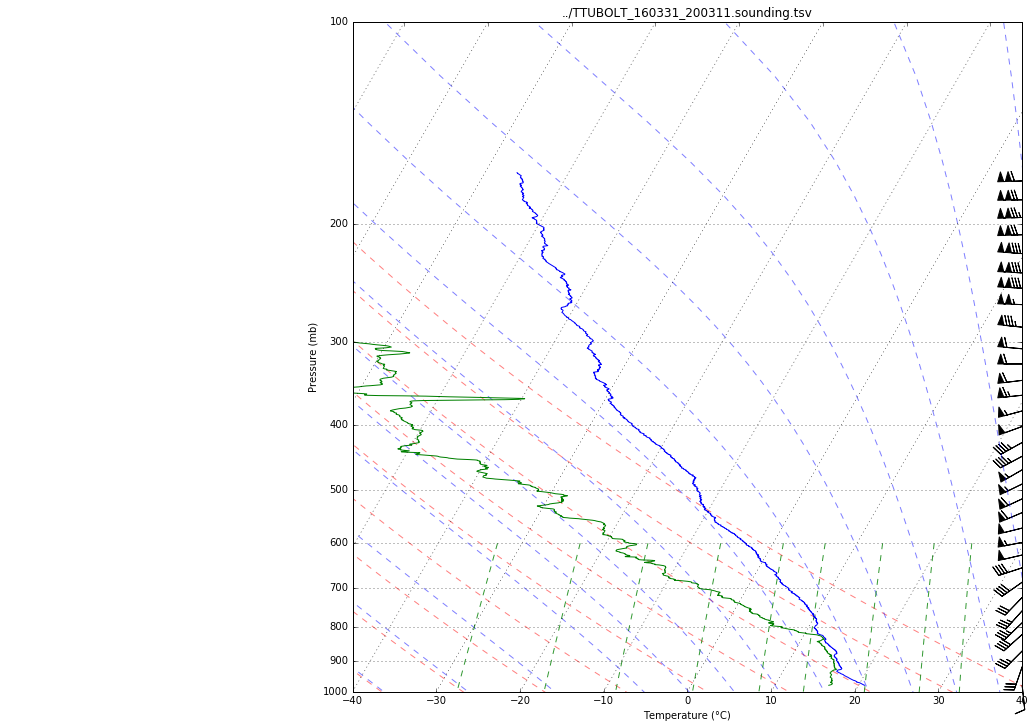

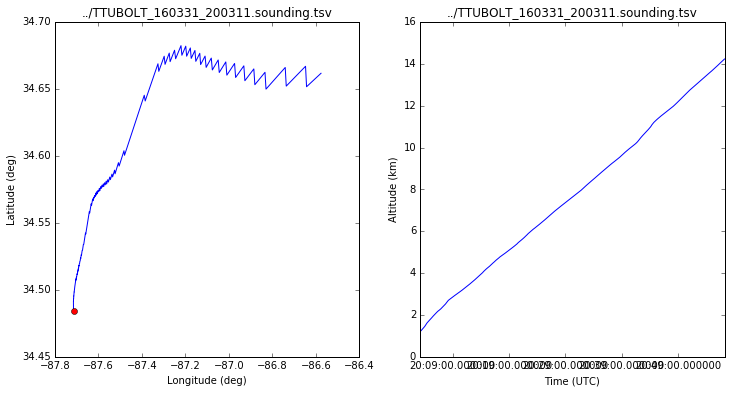

In [13]:
snd = SoundingPostProcessor(mar31_20, start_latlon=(34.484175, -87.714565), location="Russelville, AL")
snd.plot_hodo()
snd.plot_skewt()
snd.plot_track()
# snd.print_raw_data(0, 20)
outfile = snd.launch.strftime("%Y%m%d_%H%MZ_TTU_{0}.txt".format(snd.location.replace(" ", "").replace(",", "")))
snd.save_filtered(outfile)

# VORTEX-SE TTU Radiosonde Data
# 2016-03-31, 2208 UTC, Russelville, AL
# latitude (deg), longitude (deg), UTC time from launch (HHMMSS), height (m AGL), pressure (mb), temp (deg C), mixing ratio (g/kg), wind speed (m/s), wind direction (deg)

Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.
Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.


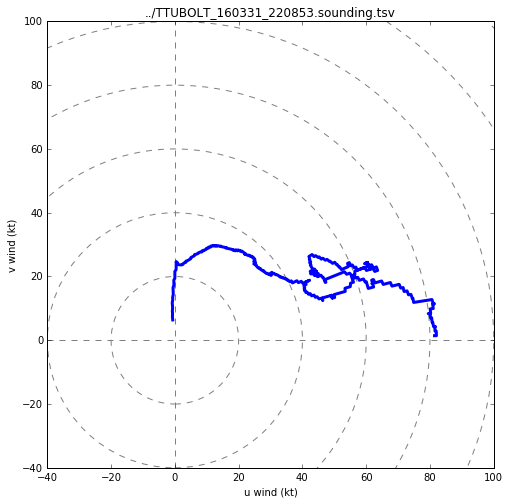

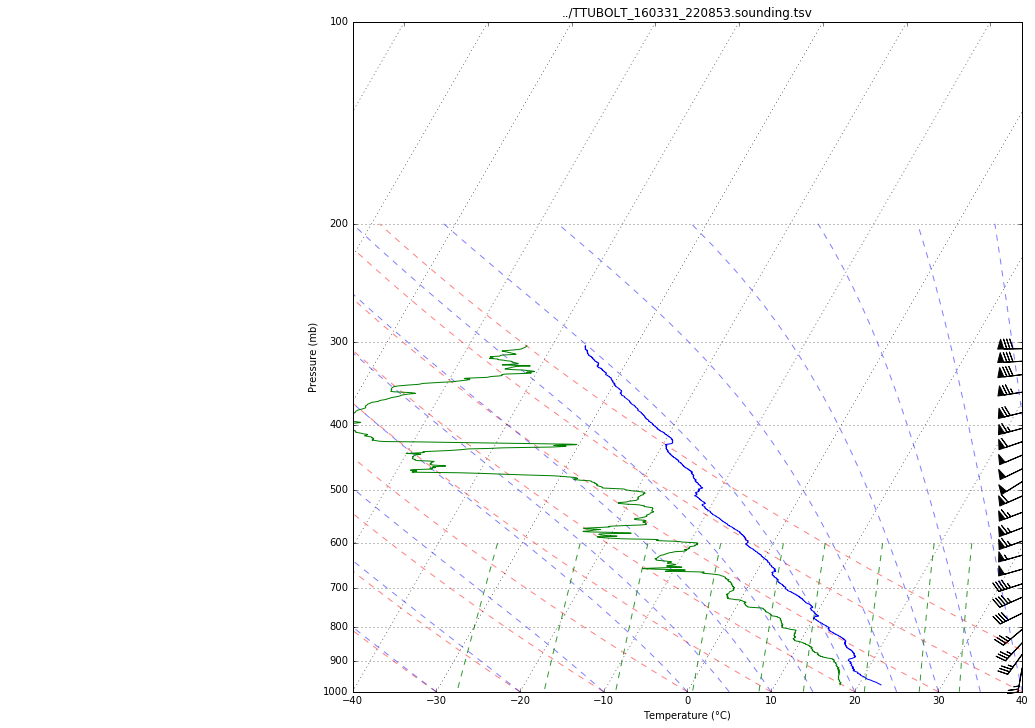

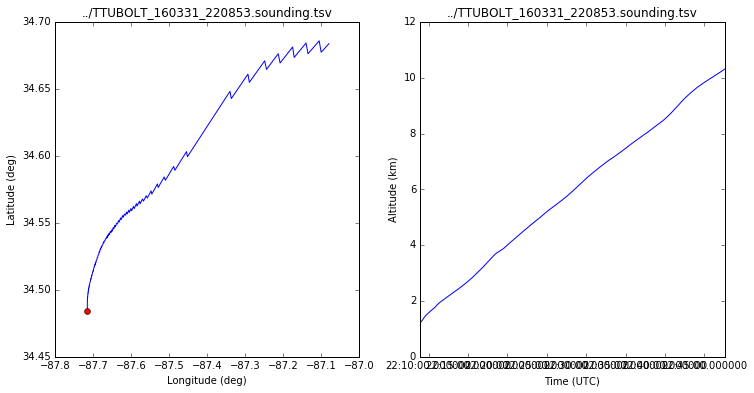

In [14]:
snd = SoundingPostProcessor(mar31_22, start_latlon=(34.484175, -87.714565), location="Russelville, AL")
uv_filt = snd.filters['uv']
uv_filt[[0,1,2]] = True
snd.filters['uv'] = uv_filt

snd.plot_hodo()
snd.plot_skewt()
snd.plot_track()
# snd.print_raw_data(0, 20)
# snd.print_raw_data(-10, -1, 1)
outfile = snd.launch.strftime("%Y%m%d_%H%MZ_TTU_{0}.txt".format(snd.location.replace(" ", "").replace(",", "")))
snd.save_filtered(outfile)

# VORTEX-SE TTU Radiosonde Data
# 2016-03-31, 2331 UTC, Russelville, AL
# latitude (deg), longitude (deg), UTC time from launch (HHMMSS), height (m AGL), pressure (mb), temp (deg C), mixing ratio (g/kg), wind speed (m/s), wind direction (deg)

Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.
Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.


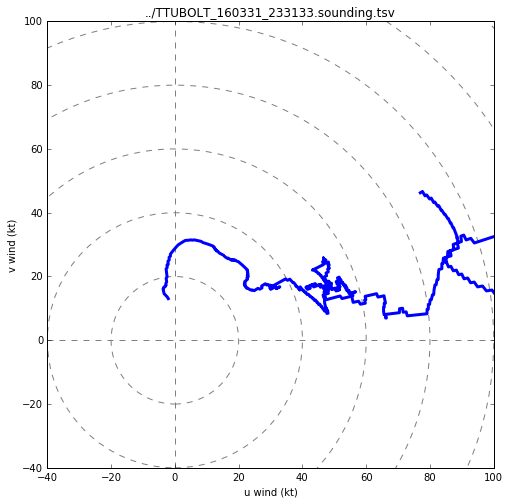

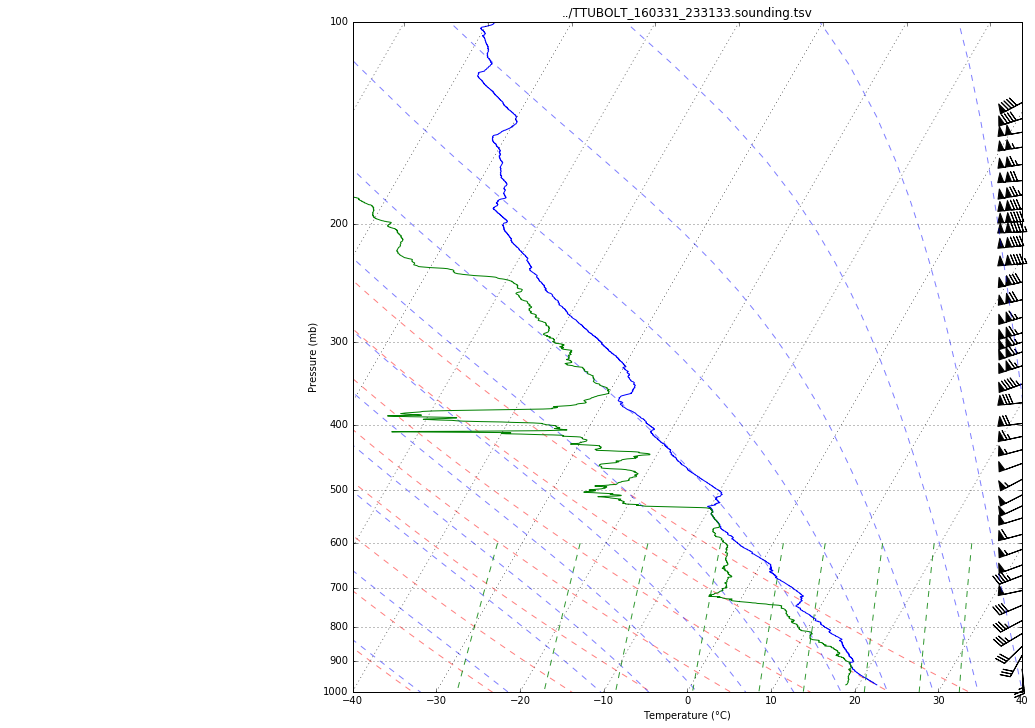

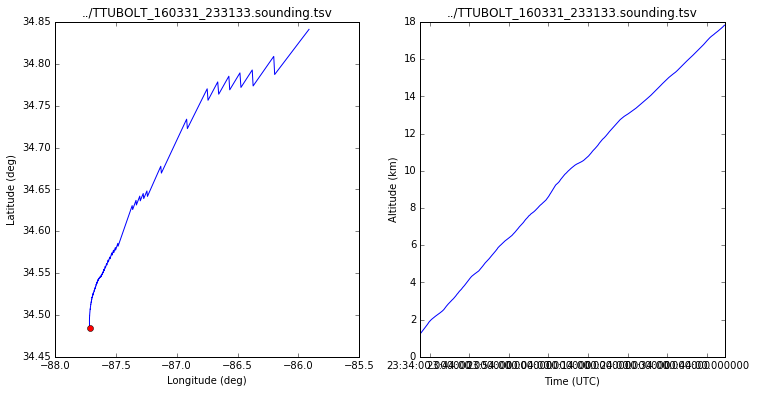

In [15]:
snd = SoundingPostProcessor(mar31_23, start_latlon=(34.484175, -87.714565), location="Russelville, AL")
uv_filt = snd.filters['uv']
uv_filt[[0,1,2,3,4,5,6,7,8,9,10,11,12]] = True
snd.filters['uv'] = uv_filt

snd.plot_hodo()
snd.plot_skewt()
snd.plot_track()
# snd.print_raw_data(0, 20)
outfile = snd.launch.strftime("%Y%m%d_%H%MZ_TTU_{0}.txt".format(snd.location.replace(" ", "").replace(",", "")))
snd.save_filtered(outfile)

# VORTEX-SE TTU Radiosonde Data
# 2016-04-01, 0101 UTC, Hartselle, AL
# latitude (deg), longitude (deg), UTC time from launch (HHMMSS), height (m AGL), pressure (mb), temp (deg C), mixing ratio (g/kg), wind speed (m/s), wind direction (deg)

Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.
Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.


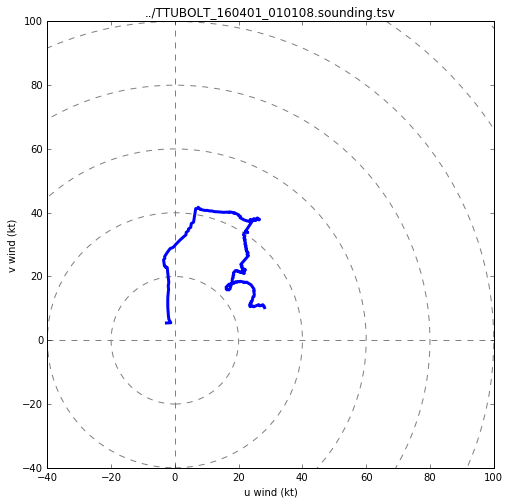

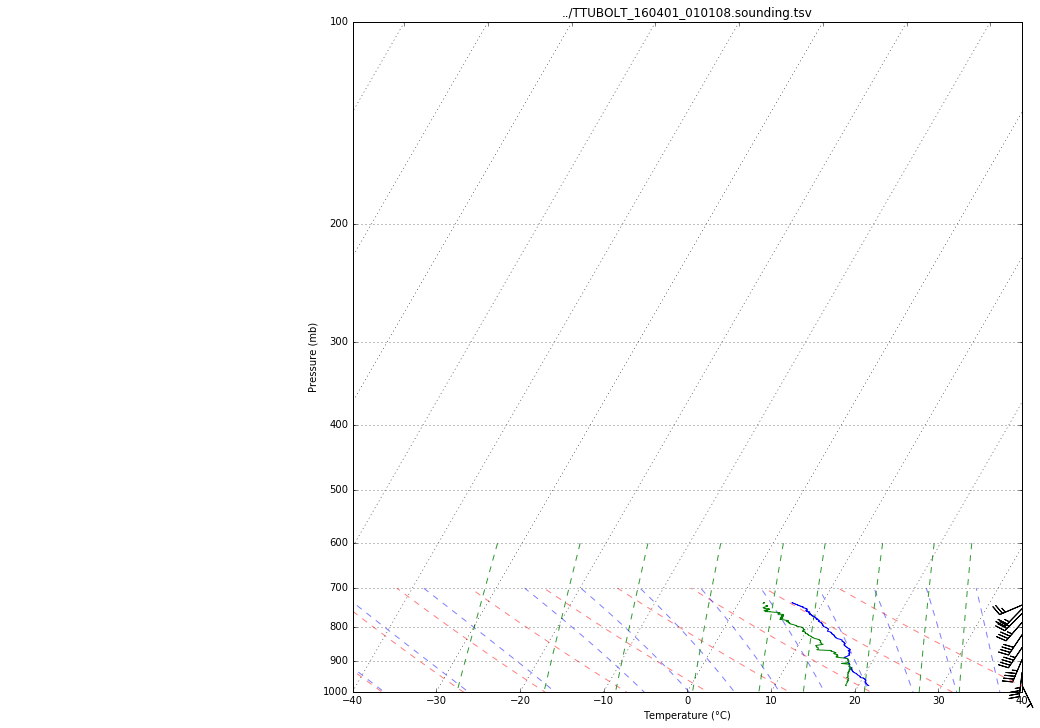

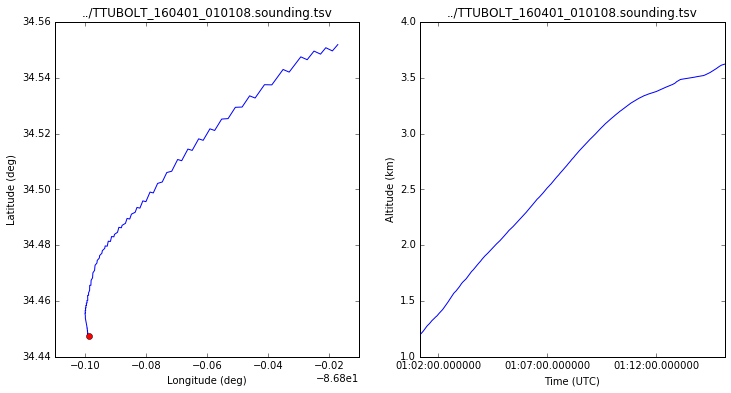

In [16]:
snd = SoundingPostProcessor(apr01_01, start_latlon=(34.447600, -86.898953), location="Hartselle, AL")
RH_filt = snd.filters['RH']
RH_filt[range(397,411,1)] = True
snd.filters['RH'] = RH_filt
snd.filters['Td'] = RH_filt

snd.plot_hodo()
snd.plot_skewt()
snd.plot_track()
# snd.print_raw_data(0, 20)

outfile = snd.launch.strftime("%Y%m%d_%H%MZ_TTU_{0}.txt".format(snd.location.replace(" ", "").replace(",", "")))
snd.save_filtered(outfile)

# VORTEX-SE TTU Radiosonde Data
# 2016-04-01, 0204 UTC, Cullman, AL
# latitude (deg), longitude (deg), UTC time from launch (HHMMSS), height (m AGL), pressure (mb), temp (deg C), mixing ratio (g/kg), wind speed (m/s), wind direction (deg)

Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.
Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.


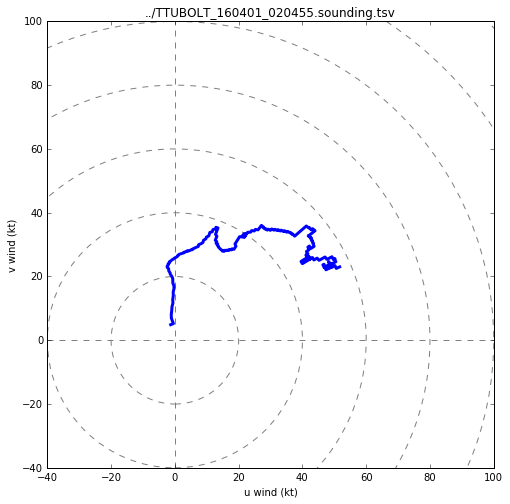

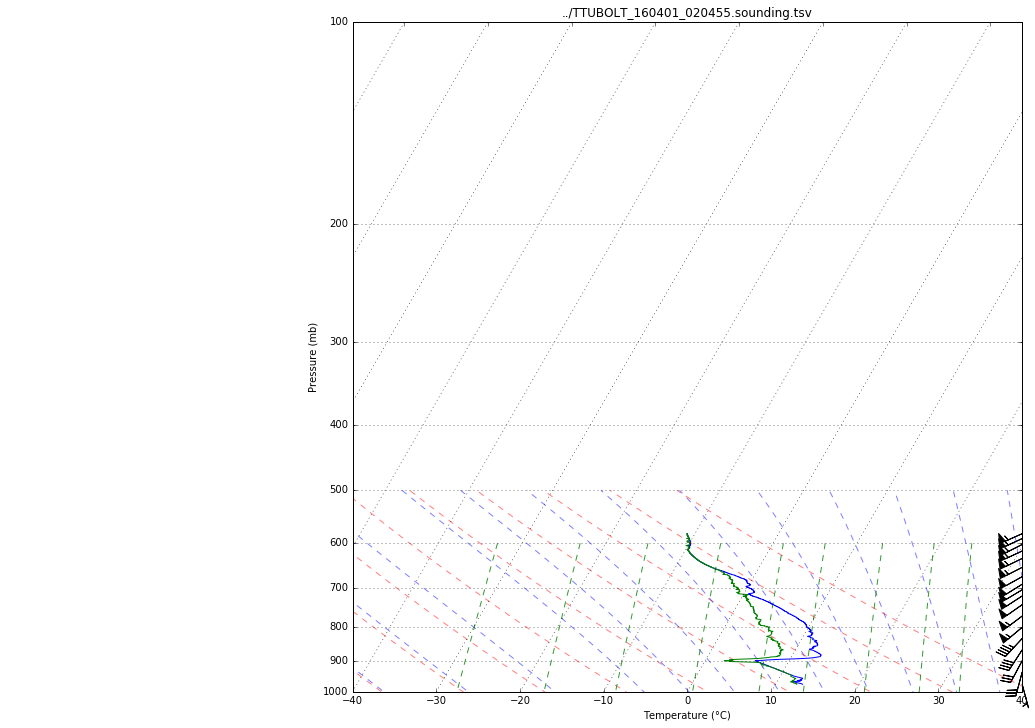

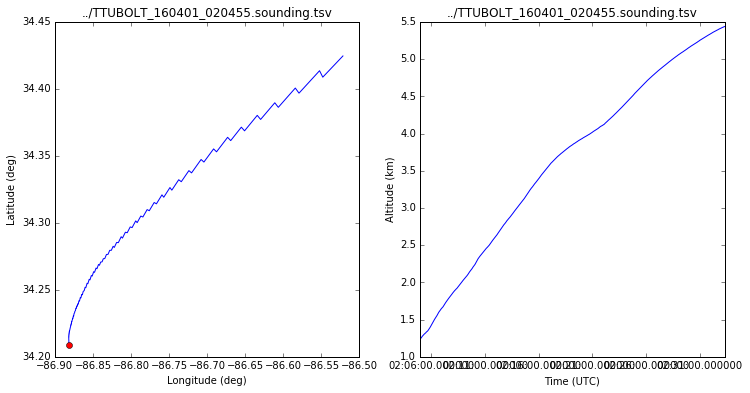

In [17]:
snd = SoundingPostProcessor(apr01_02, start_latlon=(34.208442, -86.881505), location="Cullman, AL")
# --- thermo on this sounding is sketchy --- probably don't want to distribute.
snd.plot_hodo()
snd.plot_skewt()
snd.plot_track()
# snd.print_raw_data(0, 20)
outfile = snd.launch.strftime("%Y%m%d_%H%MZ_TTU_{0}.txt".format(snd.location.replace(" ", "").replace(",", "")))
snd.save_filtered(outfile)

## April 27 2016

DARTS at Moulton Rec Ctr
- 34.4800 -87.3081
- Deployed 1920 UTC

Sounding at Trinity, AL Municipal Services / Ballfields with Purdue
- 34.6104, -87.0861
- Launches
    - PUR 1808 UTC
    - TTU 2000 UTC
    - PUR 2059 UTC
    - TTU 2306 UTC


# VORTEX-SE TTU Radiosonde Data
# 2016-04-27, 2000 UTC, Trinity, AL
# latitude (deg), longitude (deg), UTC time from launch (HHMMSS), height (m AGL), pressure (mb), temp (deg C), mixing ratio (g/kg), wind speed (m/s), wind direction (deg)

Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.
Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.


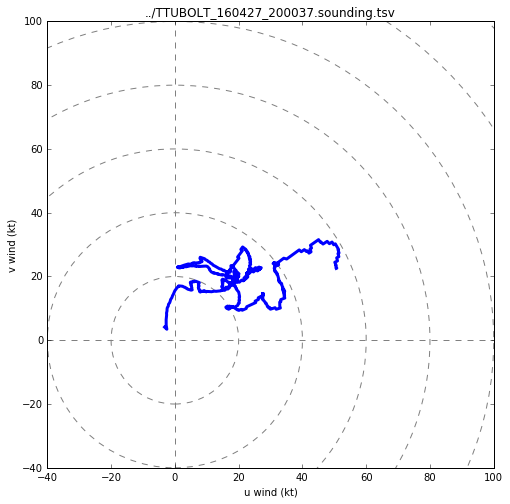

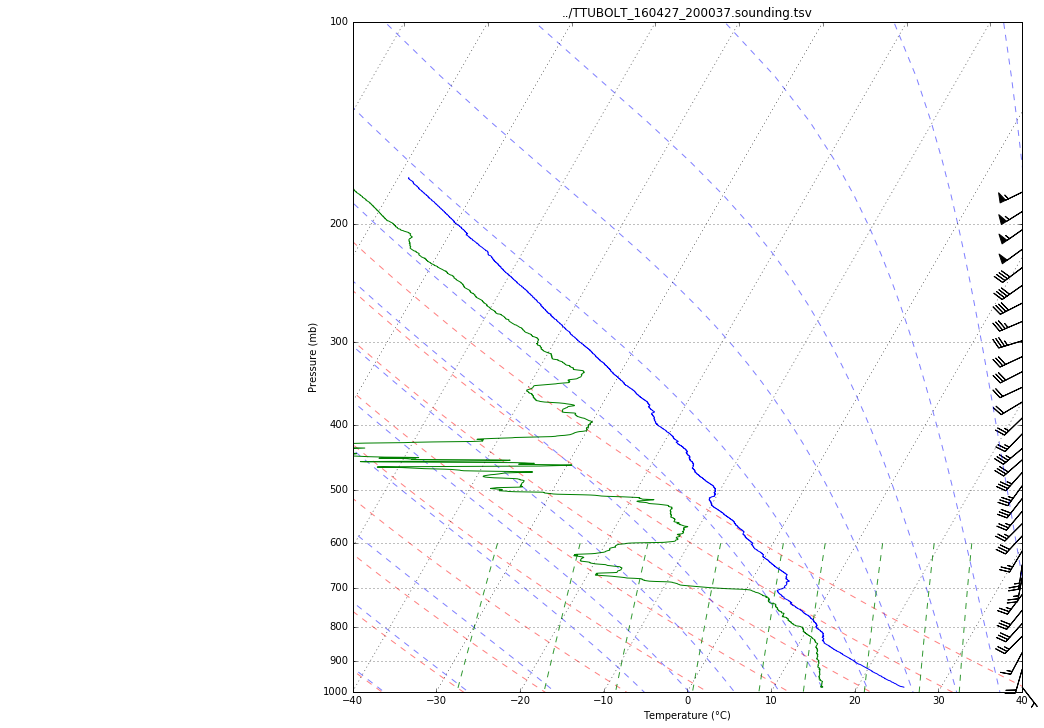

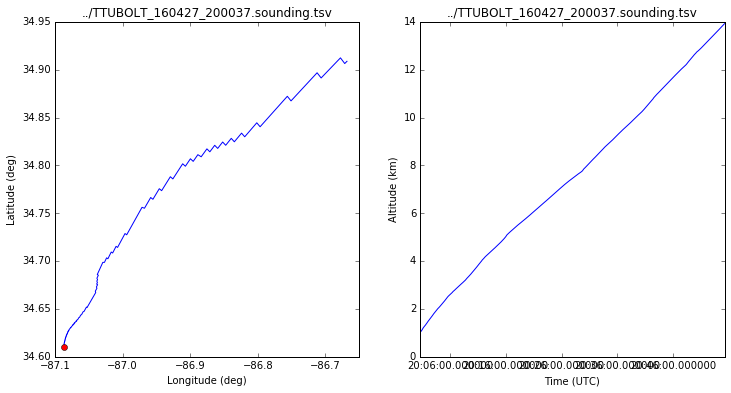

In [18]:
snd = SoundingPostProcessor(apr27_20, start_latlon=(34.6104, -87.0861), location="Trinity, AL")

snd.plot_hodo()
snd.plot_skewt()
snd.plot_track()
# snd.print_raw_data(0, 30)
outfile = snd.launch.strftime("%Y%m%d_%H%MZ_TTU_{0}.txt".format(snd.location.replace(" ", "").replace(",", "")))
snd.save_filtered(outfile)

# VORTEX-SE TTU Radiosonde Data
# 2016-04-27, 2306 UTC, Trinity, AL
# latitude (deg), longitude (deg), UTC time from launch (HHMMSS), height (m AGL), pressure (mb), temp (deg C), mixing ratio (g/kg), wind speed (m/s), wind direction (deg)

Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.
Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.


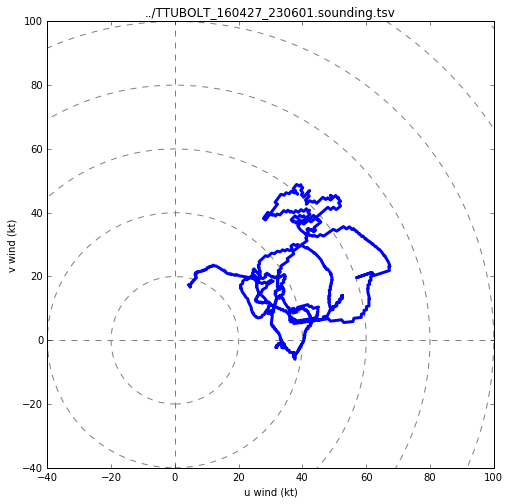

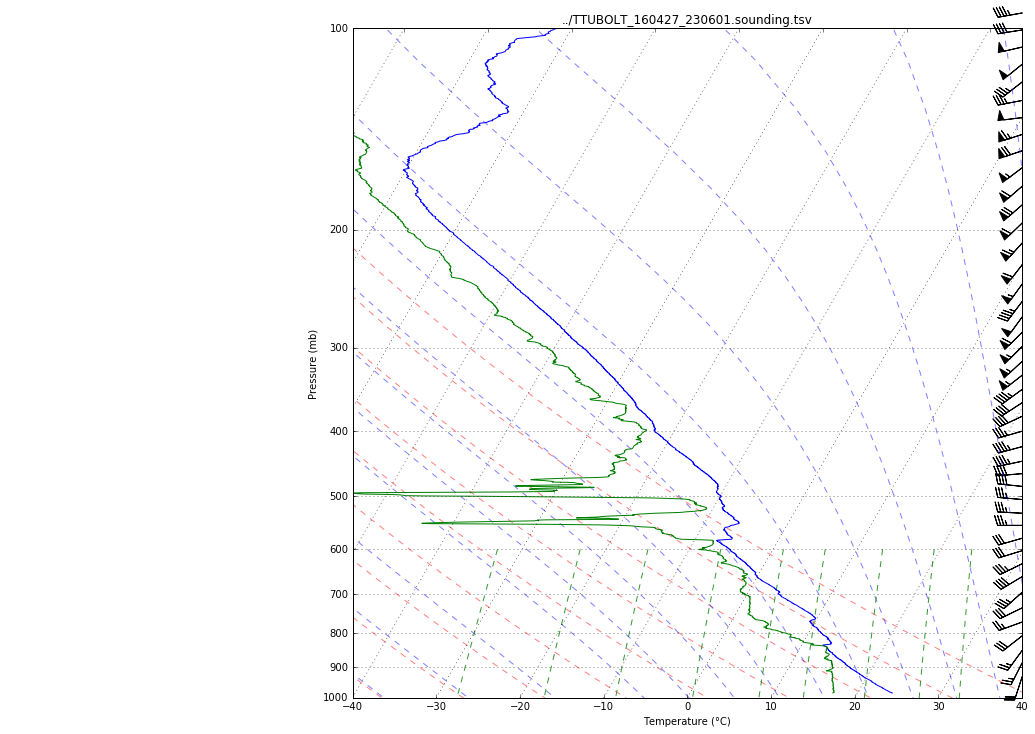

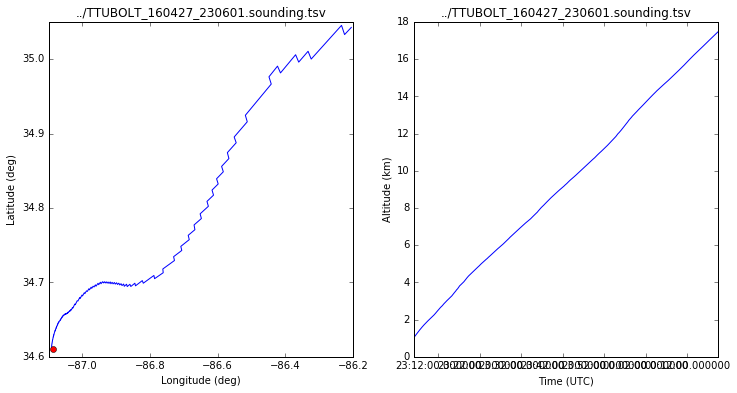

In [19]:
snd = SoundingPostProcessor(apr27_23, start_latlon=(34.6104, -87.0861), location="Trinity, AL")
uv_filt = snd.filters['uv']
uv_filt[range(0,30)] = True
snd.filters['uv'] = uv_filt

snd.plot_hodo()
snd.plot_skewt()
snd.plot_track()
# snd.print_raw_data(0, 35)
outfile = snd.launch.strftime("%Y%m%d_%H%MZ_TTU_{0}.txt".format(snd.location.replace(" ", "").replace(",", "")))
snd.save_filtered(outfile)

## April 29 2016

DARTS at Moulton Rec Ctr
- 34.4792 -87.3043
Deployed  1945 UTC

Sounding in near inflow south of Eldridge, AL
- 33.842762, -87.648562
- Launch at 2109 UTC

Sounding in cold pool on AL 13, which runs south from Bankston and Berry, AL
- 33.5757, -87.6586
- Launch at 2255 UTC



# VORTEX-SE TTU Radiosonde Data
# 2016-04-29, 2110 UTC, Eldridge, AL
# latitude (deg), longitude (deg), UTC time from launch (HHMMSS), height (m AGL), pressure (mb), temp (deg C), mixing ratio (g/kg), wind speed (m/s), wind direction (deg)

Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.
Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.


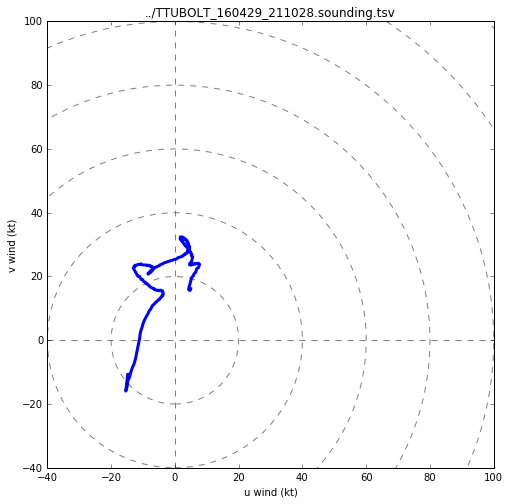

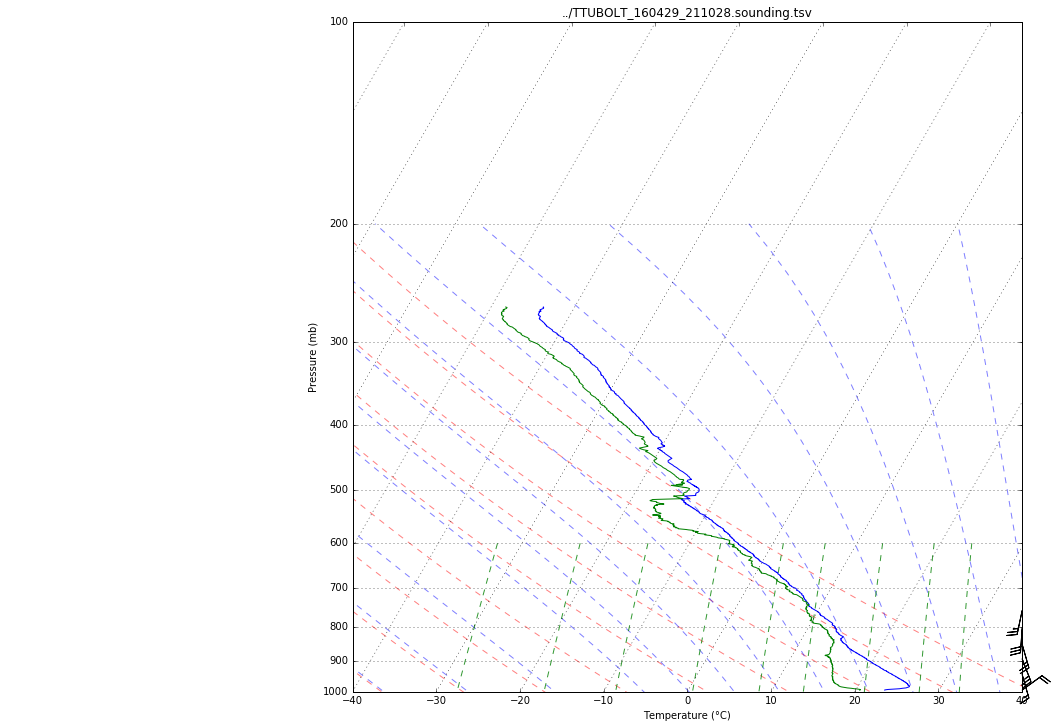

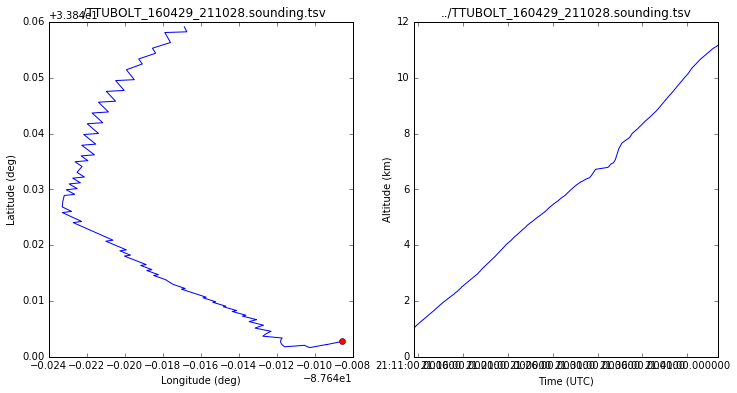

In [20]:
snd = SoundingPostProcessor(apr29_21, start_latlon=(33.842762, -87.648562), location="Eldridge, AL")

snd.plot_hodo()
snd.plot_skewt()
snd.plot_track()
# snd.print_raw_data(0, 30)
outfile = snd.launch.strftime("%Y%m%d_%H%MZ_TTU_{0}.txt".format(snd.location.replace(" ", "").replace(",", "")))
snd.save_filtered(outfile)

# VORTEX-SE TTU Radiosonde Data
# 2016-04-29, 2255 UTC, Bankston, AL
# latitude (deg), longitude (deg), UTC time from launch (HHMMSS), height (m AGL), pressure (mb), temp (deg C), mixing ratio (g/kg), wind speed (m/s), wind direction (deg)

Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.
Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.


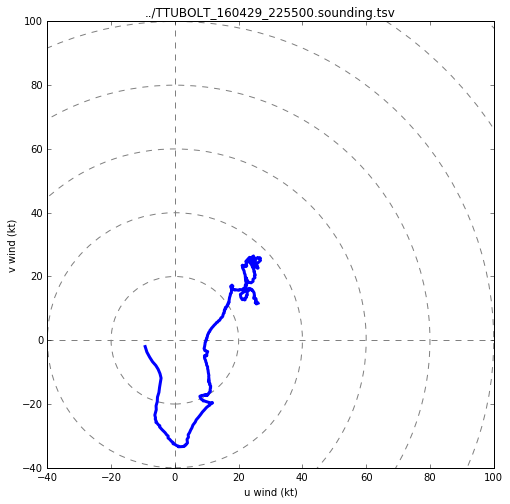

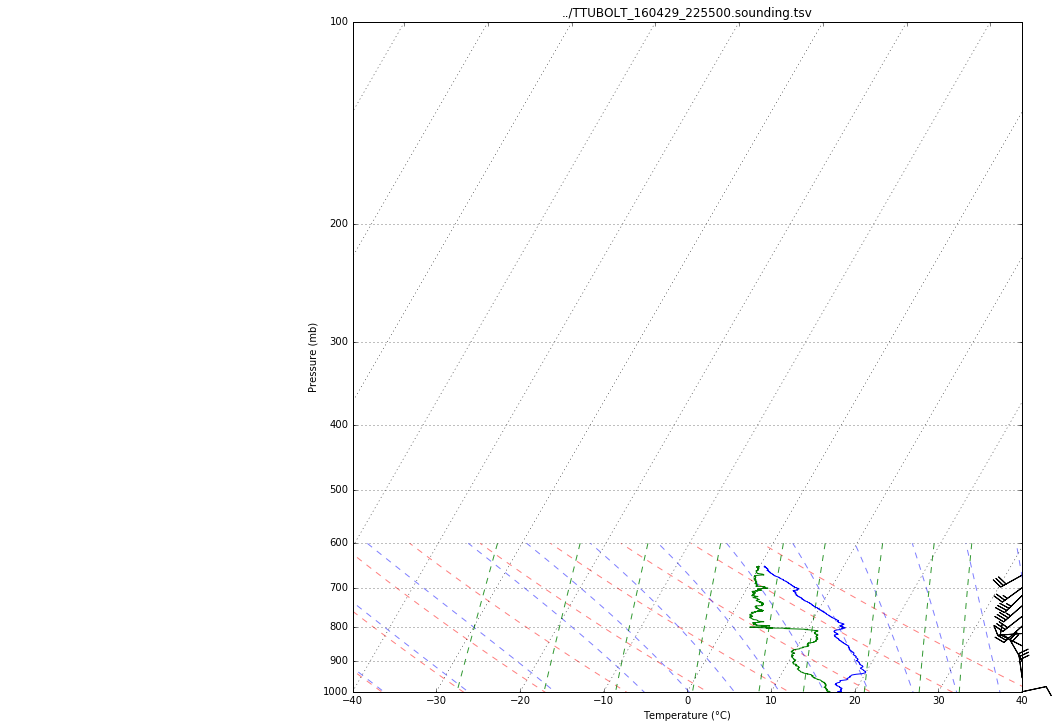

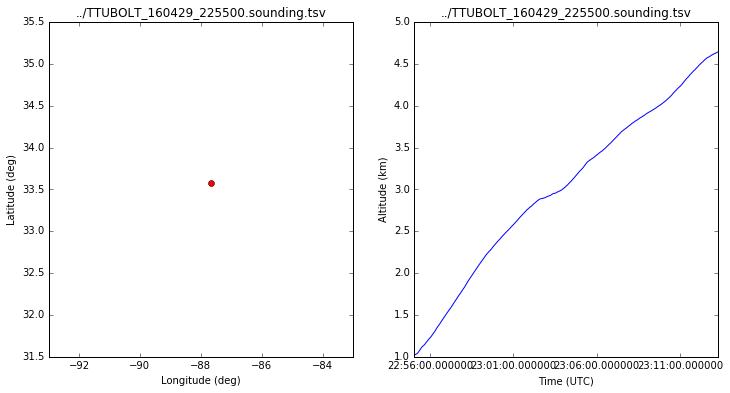

In [21]:
TSVdummyHeader=(
"""
Information about map: EDT                 
==================================

Map name (internal)     : EDT000
Sounding set (internal) : 
RS-Number               : 
Data record length      : 
Number of data records  : 
Max filemap size        : 
Data header size        : 
Free space in map       : 
Status flag (not used)  : 


   Record name:    Unit:           Data type:          Divisor: Offset:
   ---------------------------------------------------------------------
    time            sec             float (4)          1        0       
    Pscl            ln              short (2)          1        0       
    T               K               short (2)          10       0       
    RH              %               short (2)          1        0       
    v               m/s             short (2)          -100     0       
    u               m/s             short (2)          -100     0       
    Height          m               short (2)          1        30000   
    P               hPa             short (2)          10       0       
    TD              K               short (2)          10       0       
    MR              g/kg            short (2)          100      0       
    DD              dgr             short (2)          1        0       
    FF              m/s             short (2)          10       0       
    AZ              dgr             short (2)          1        0       
    Range           m               short (2)          0.01     0       
    Lon             dgr             short (2)          100      0       
    Lat             dgr             short (2)          100      0       
    SpuKey          bitfield        unsigned short (2) 1        0       
    UsrKey          bitfield        unsigned short (2) 1        0       
    RadarH          m               short (2)          1        30000   

*************************************************************************************************


"""
)

from metpy.calc import dewpoint_rh, get_wind_components

def read_recovered_write_tsv(filename, filename_out, skip=2):
    data_in = np.loadtxt(filename, dtype=[('time','f4'), ('Height','f4'), 
                                       ('P','f4'), ('T','f4'), ('RH','f4'),
                                       ('wspd','f4'),('wdir','f4'), 
                                       ], skiprows=skip)

    data = np.zeros_like(data_in, dtype=tsv_dtype)
    for name in data.dtype.names:
        data[name] = -32768

    for name in data_in.dtype.names:
        data[name] = data_in[name]
        
    
    T_K = (data['T']*units.celsius).to(units.kelvin)
    Td = dewpoint_rh(T_K, data['RH']*units.percent)
    Td_K = Td.to(units.kelvin)
    u, v = get_wind_components(data['wspd']*units.meter/units.second, data['wdir']*units.degree)
    data['TD'] = Td_K
    data['T'] = T_K
    data['u'] = u
    data['v'] = v
        
    np.savetxt(filename_out, data, fmt='%8.2f', delimiter='\t', header=TSVdummyHeader)
    
    return data

recovered_apr29_23 = '../TTUBOLT_160429_225500.sounding.txt'
apr29_23_tsvout = '../TTUBOLT_160429_225500.sounding.tsv'
data = read_recovered_write_tsv(recovered_apr29_23, apr29_23_tsvout)

snd = SoundingPostProcessor(apr29_23, start_latlon=(33.5757, -87.6586), location="Bankston, AL")

snd.plot_hodo()
snd.plot_skewt()
snd.plot_track()
# snd.print_raw_data(0, 10)

outfile = snd.launch.strftime("%Y%m%d_%H%MZ_TTU_{0}.txt".format(snd.location.replace(" ", "").replace(",", "")))
snd.save_filtered(outfile)

## April 30 2016

DARTS info not in log

Sounding at Tuscumbia / Muscle Shoals Love's
- 34.697462, -87.635408
- Launches at 
    - 1606 UTC
    - 1800 UTC
    - 2000 UTC (very full balloon)


Sounding at Cty line on 157 W of Hartselle at/on CR200 near Danville. Near StickNet array.
- 34.394782, -87.118475
- Launch at 2140 UTC



# VORTEX-SE TTU Radiosonde Data
# 2016-04-30, 1605 UTC, Tuscumbia, AL
# latitude (deg), longitude (deg), UTC time from launch (HHMMSS), height (m AGL), pressure (mb), temp (deg C), mixing ratio (g/kg), wind speed (m/s), wind direction (deg)

Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.
Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.


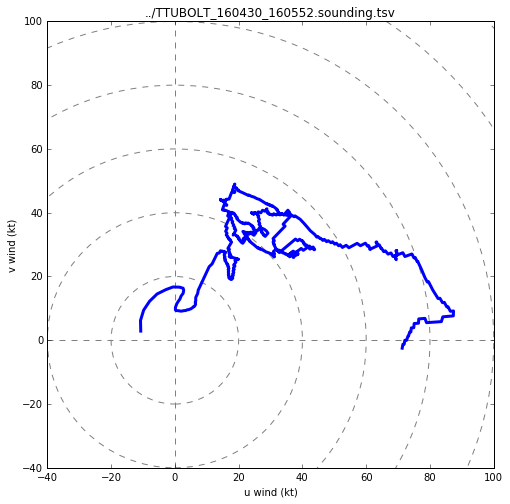

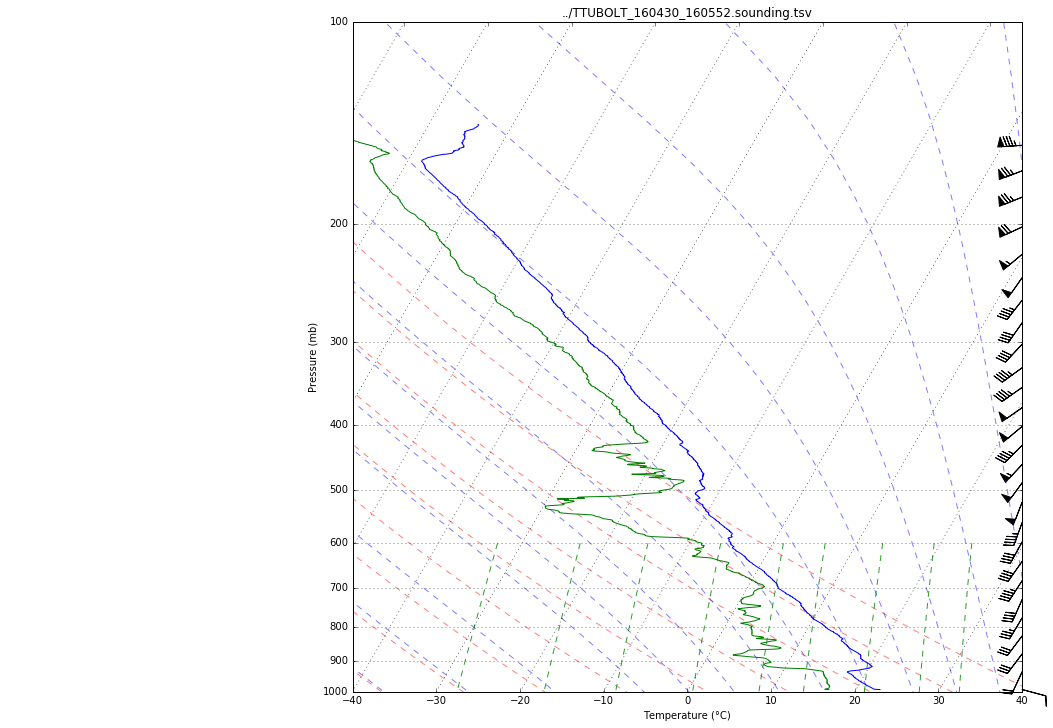

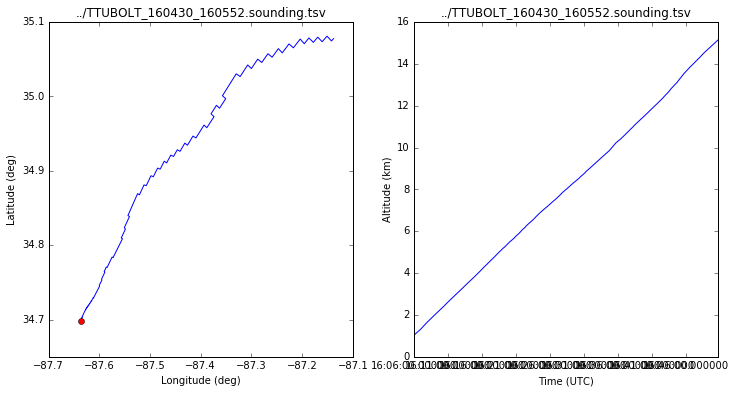

In [22]:
snd = SoundingPostProcessor(apr30_16, start_latlon=(34.697462, -87.635408), location="Tuscumbia, AL")

snd.plot_hodo()
snd.plot_skewt()
snd.plot_track()
# snd.print_raw_data(0, 10)

outfile = snd.launch.strftime("%Y%m%d_%H%MZ_TTU_{0}.txt".format(snd.location.replace(" ", "").replace(",", "")))
snd.save_filtered(outfile)

# VORTEX-SE TTU Radiosonde Data
# 2016-04-30, 1800 UTC, Tuscumbia, AL
# latitude (deg), longitude (deg), UTC time from launch (HHMMSS), height (m AGL), pressure (mb), temp (deg C), mixing ratio (g/kg), wind speed (m/s), wind direction (deg)

Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.
Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.


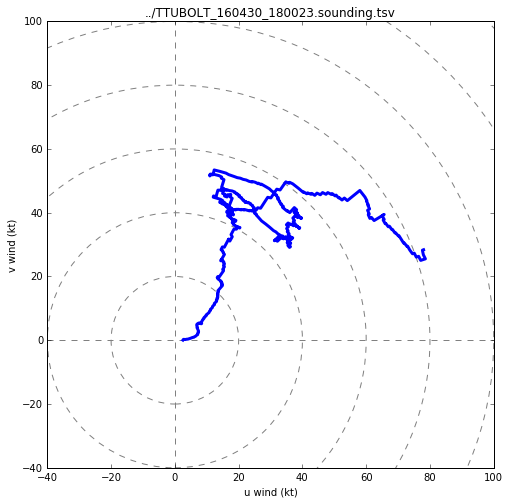

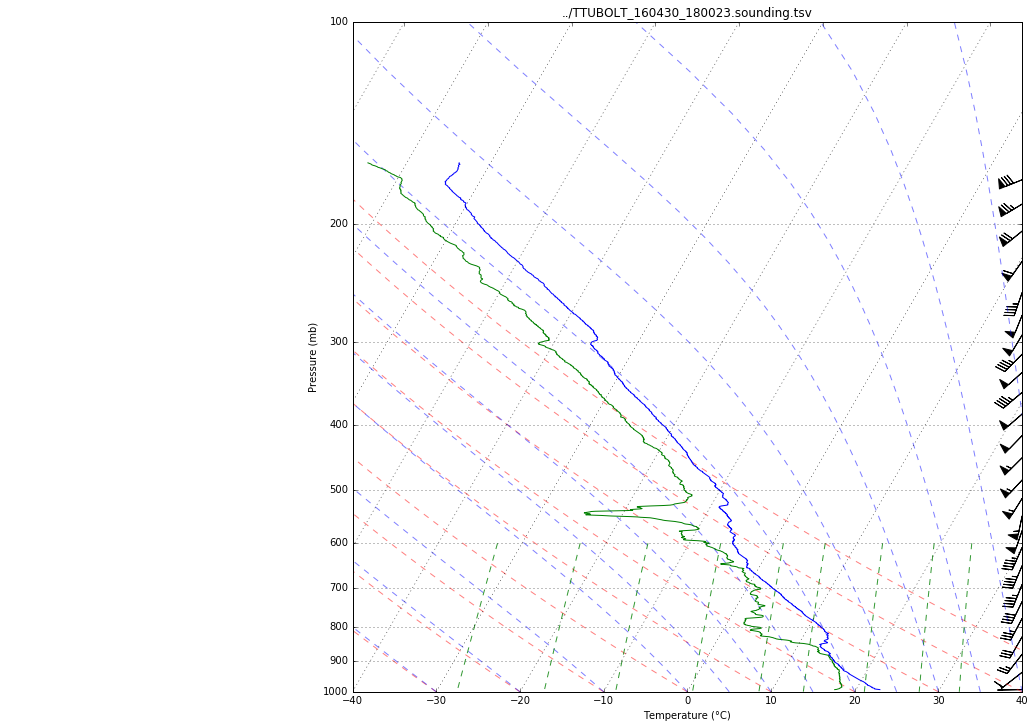

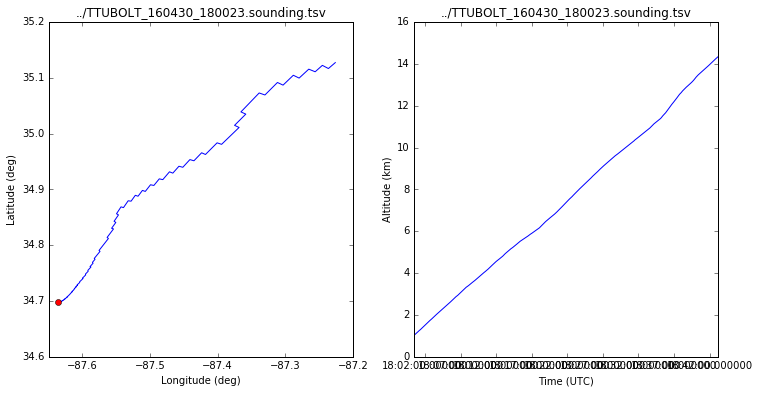

In [23]:
snd = SoundingPostProcessor(apr30_18, start_latlon=(34.697462, -87.635408), location="Tuscumbia, AL")

snd.plot_hodo()
snd.plot_skewt()
snd.plot_track()
# snd.print_raw_data(0, 10)

outfile = snd.launch.strftime("%Y%m%d_%H%MZ_TTU_{0}.txt".format(snd.location.replace(" ", "").replace(",", "")))
snd.save_filtered(outfile)

# VORTEX-SE TTU Radiosonde Data
# 2016-04-30, 2000 UTC, Tuscumbia, AL
# latitude (deg), longitude (deg), UTC time from launch (HHMMSS), height (m AGL), pressure (mb), temp (deg C), mixing ratio (g/kg), wind speed (m/s), wind direction (deg)

Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.
Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.


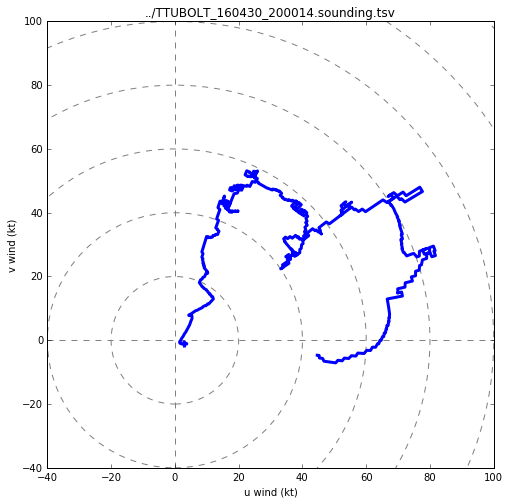

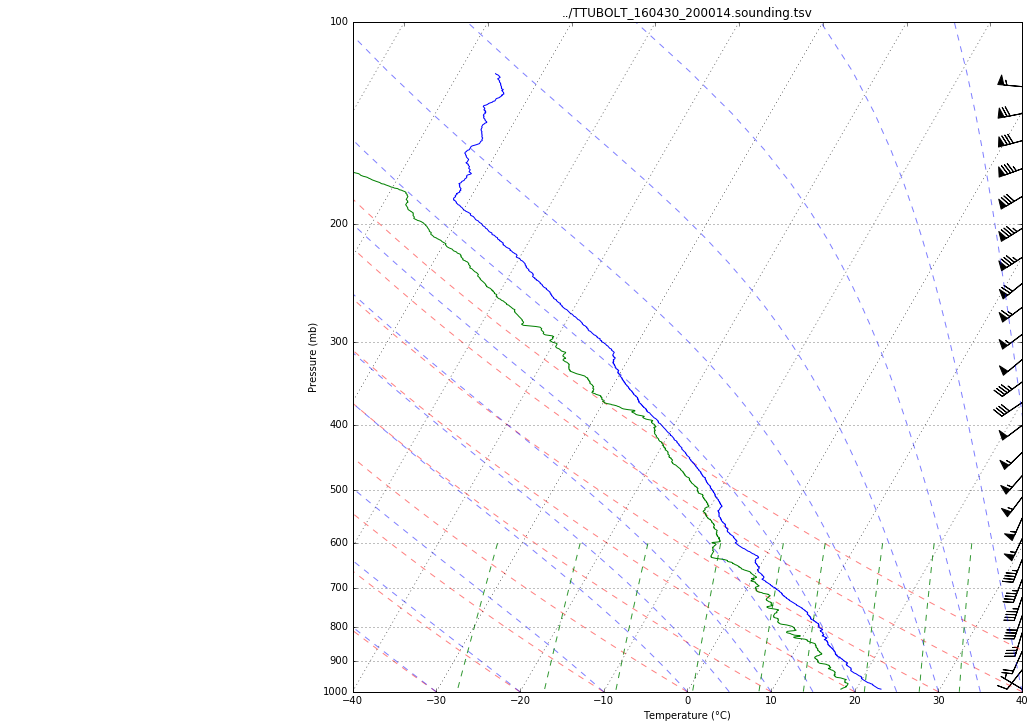

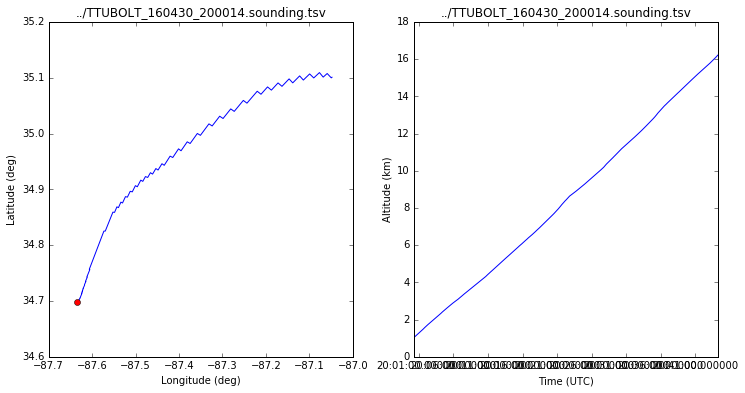

In [24]:
snd = SoundingPostProcessor(apr30_20, start_latlon=(34.697462, -87.635408), location="Tuscumbia, AL")

snd.plot_hodo()
snd.plot_skewt()
snd.plot_track()
# snd.print_raw_data(0, 10)
outfile = snd.launch.strftime("%Y%m%d_%H%MZ_TTU_{0}.txt".format(snd.location.replace(" ", "").replace(",", "")))
snd.save_filtered(outfile)

# VORTEX-SE TTU Radiosonde Data
# 2016-04-30, 2140 UTC, Danville, AL
# latitude (deg), longitude (deg), UTC time from launch (HHMMSS), height (m AGL), pressure (mb), temp (deg C), mixing ratio (g/kg), wind speed (m/s), wind direction (deg)

Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.
Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.


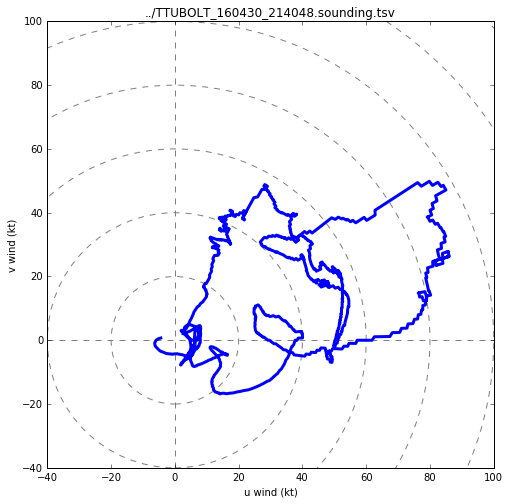

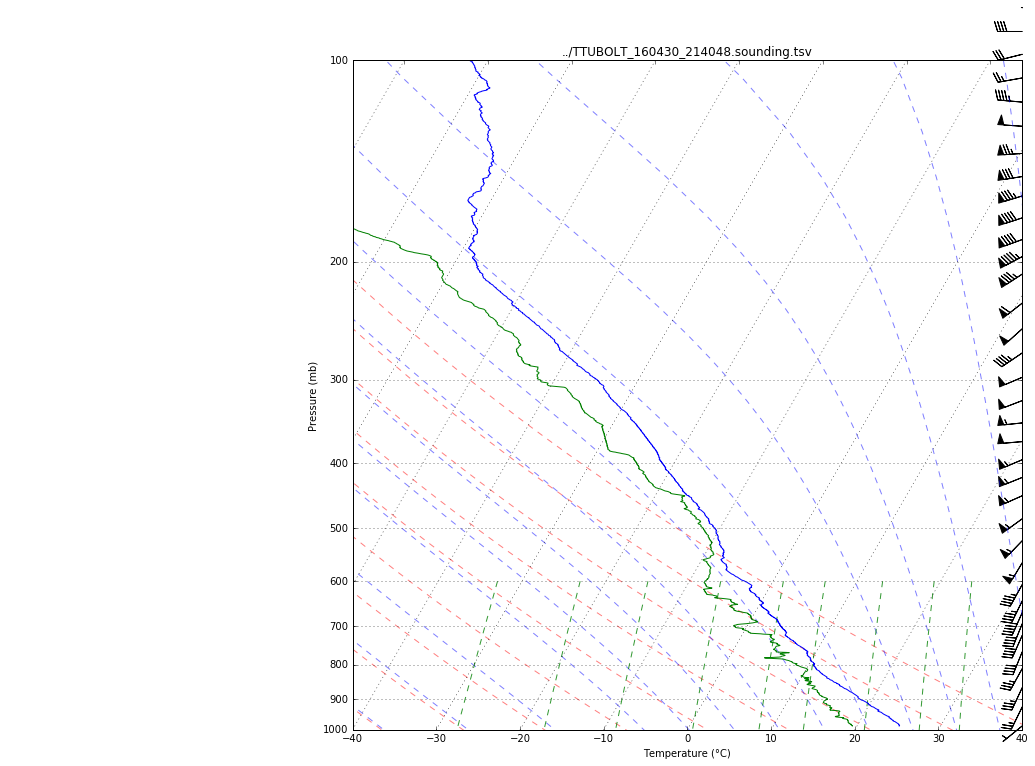

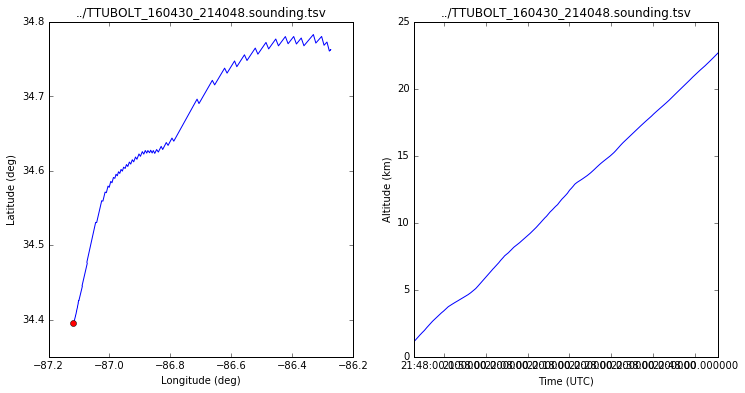

In [25]:
snd = SoundingPostProcessor(apr30_21, start_latlon=(34.394782, -87.118475), location="Danville, AL")

snd.plot_hodo()
snd.plot_skewt()
snd.plot_track()
# snd.print_raw_data(0, 10)

outfile = snd.launch.strftime("%Y%m%d_%H%MZ_TTU_{0}.txt".format(snd.location.replace(" ", "").replace(",", "")))
snd.save_filtered(outfile)

## May 1 2016

Boundary layer experiment

Soundings southeast of Pryor Field Regional Airport, at ball fields. Across the river from Decatur, AL.
- 34.643958, -86.940602
- Launches at 
    - 1630 UTC
    - 1730 UTC
    - 1842 UTC
    - 1930 UTC
    - 2030 UTC




# VORTEX-SE TTU Radiosonde Data
# 2016-05-01, 1630 UTC, Pyror Field Decatur, AL
# latitude (deg), longitude (deg), UTC time from launch (HHMMSS), height (m AGL), pressure (mb), temp (deg C), mixing ratio (g/kg), wind speed (m/s), wind direction (deg)

Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.
Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.


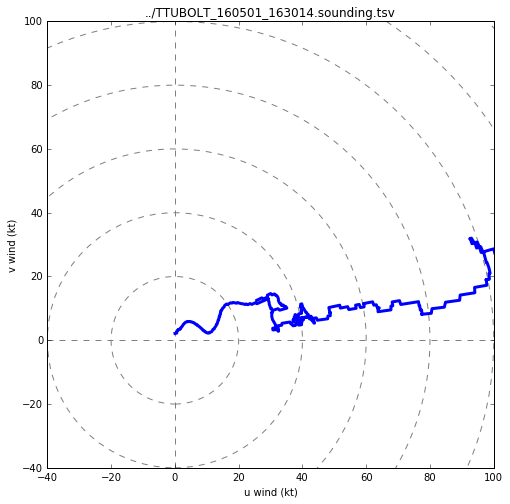

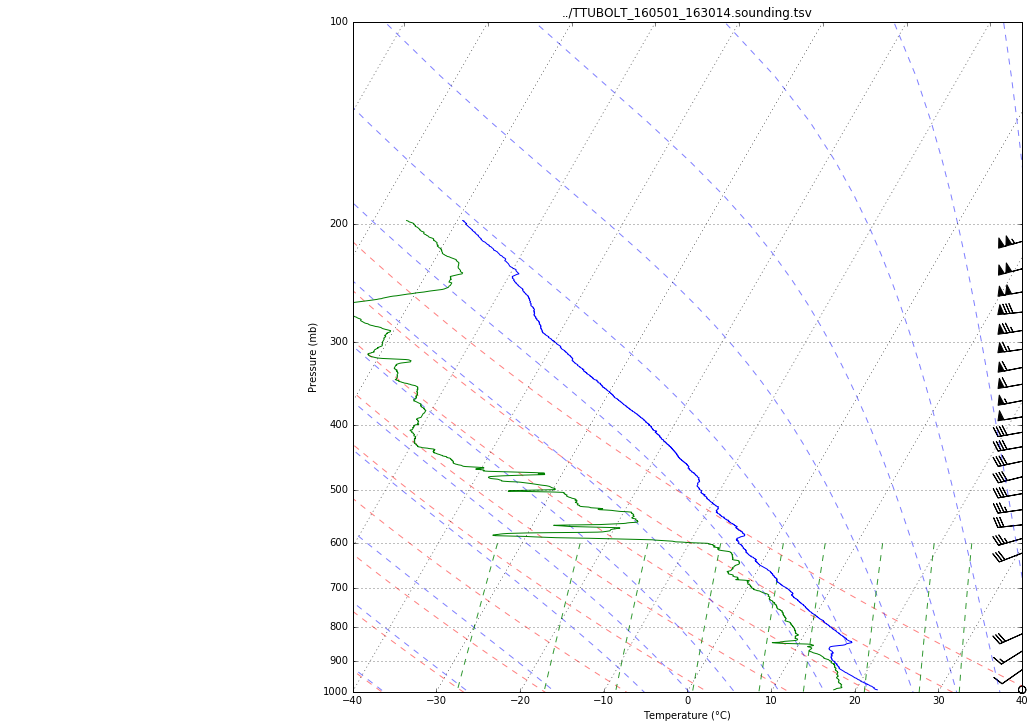

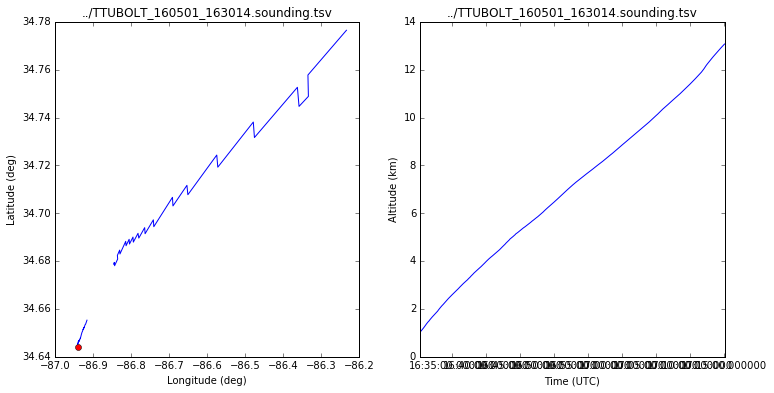

In [26]:
snd = SoundingPostProcessor(may01_16, start_latlon=(34.643958, -86.940602), location="Pyror Field Decatur, AL")

snd.plot_hodo()
snd.plot_skewt()
snd.plot_track()
# snd.print_raw_data(0, 10)

outfile = snd.launch.strftime("%Y%m%d_%H%MZ_TTU_{0}.txt".format(snd.location.replace(" ", "").replace(",", "")))
snd.save_filtered(outfile)

# VORTEX-SE TTU Radiosonde Data
# 2016-05-01, 1730 UTC, Pyror Field Decatur, AL
# latitude (deg), longitude (deg), UTC time from launch (HHMMSS), height (m AGL), pressure (mb), temp (deg C), mixing ratio (g/kg), wind speed (m/s), wind direction (deg)

Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.
Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.


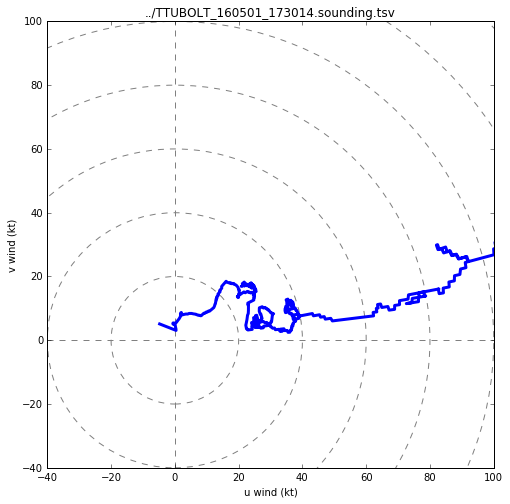

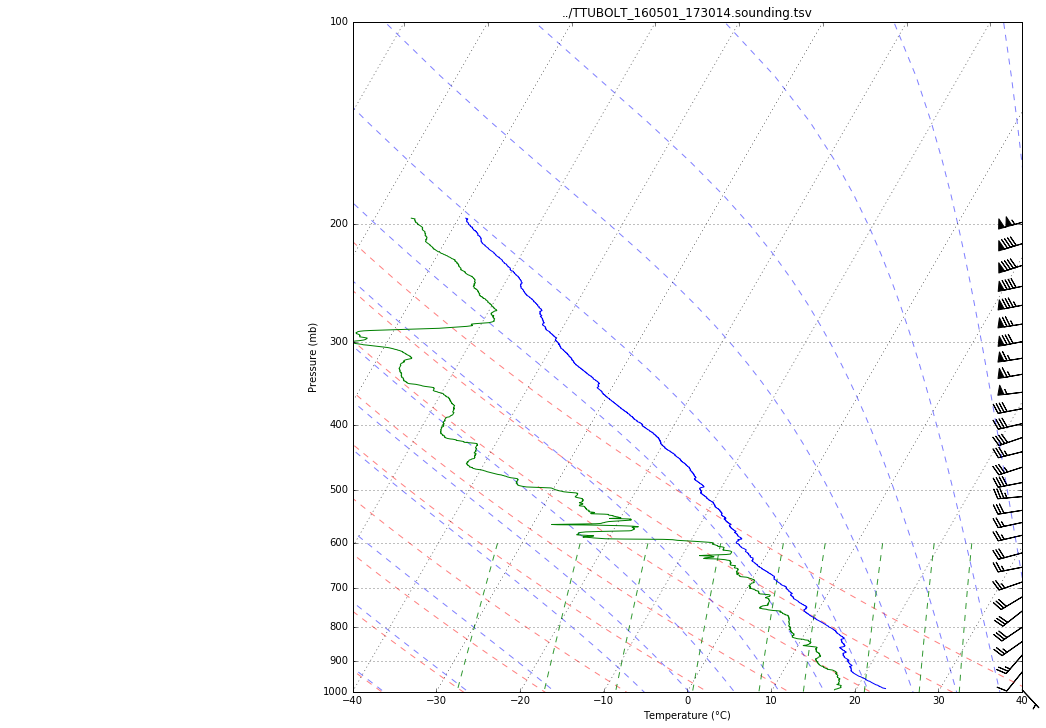

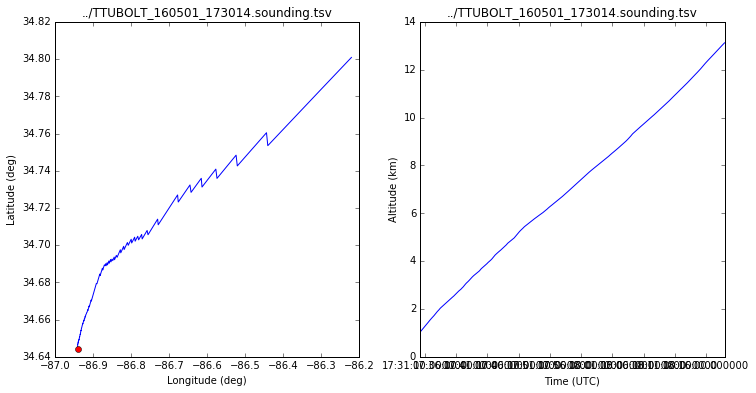

In [27]:
snd = SoundingPostProcessor(may01_17, start_latlon=(34.643958, -86.940602), location="Pyror Field Decatur, AL")
T_filt = snd.filters['T']
T_filt[[0,1,2]] = True
snd.filters['T'] = T_filt


snd.plot_hodo()
snd.plot_skewt()
snd.plot_track()
# snd.print_raw_data(0, 10)
outfile = snd.launch.strftime("%Y%m%d_%H%MZ_TTU_{0}.txt".format(snd.location.replace(" ", "").replace(",", "")))
snd.save_filtered(outfile)

# VORTEX-SE TTU Radiosonde Data
# 2016-05-01, 1842 UTC, Pyror Field Decatur, AL
# latitude (deg), longitude (deg), UTC time from launch (HHMMSS), height (m AGL), pressure (mb), temp (deg C), mixing ratio (g/kg), wind speed (m/s), wind direction (deg)

Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.
Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.


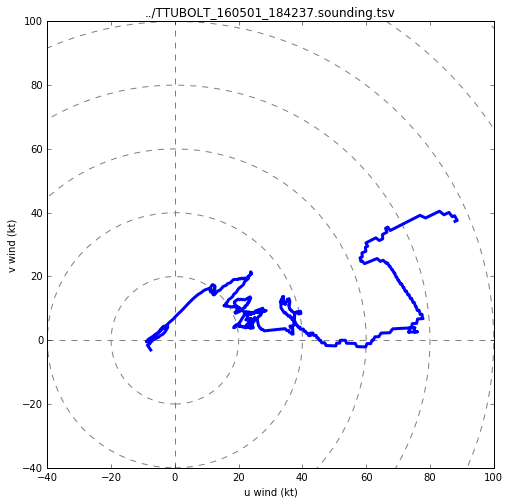

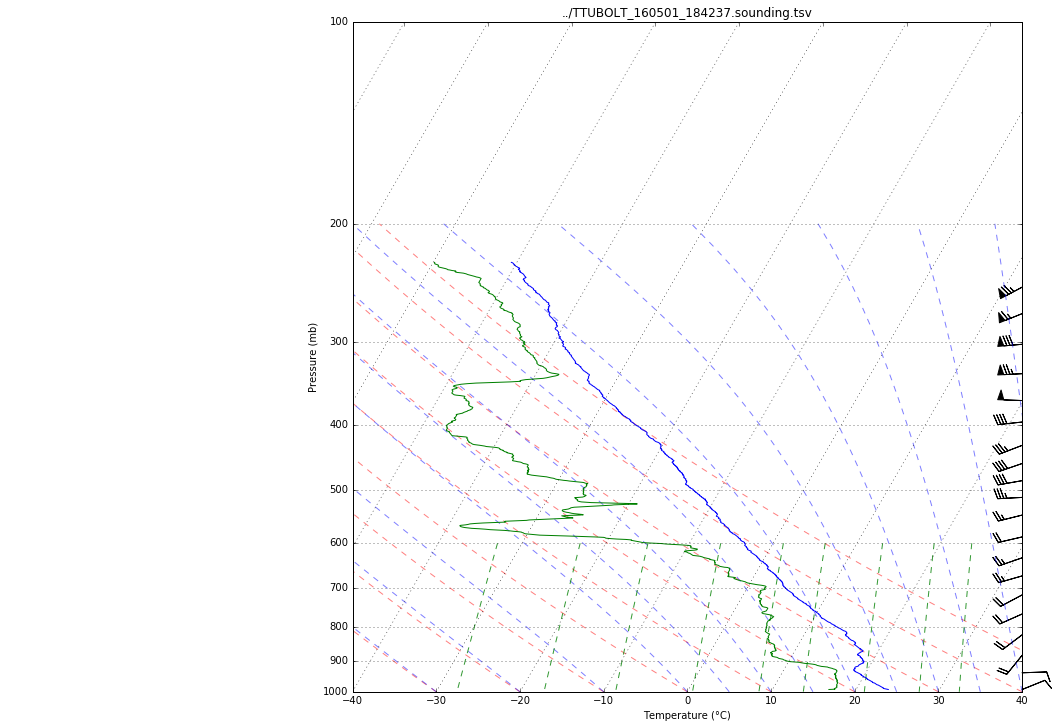

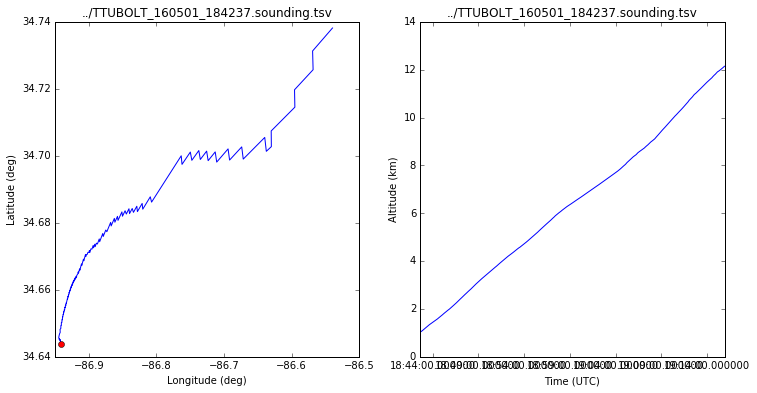

In [28]:

snd = SoundingPostProcessor(may01_18, start_latlon=(34.643958, -86.940602), location="Pyror Field Decatur, AL")
snd.plot_hodo()
snd.plot_skewt()
snd.plot_track()
# snd.print_raw_data(0, 10)
outfile = snd.launch.strftime("%Y%m%d_%H%MZ_TTU_{0}.txt".format(snd.location.replace(" ", "").replace(",", "")))
snd.save_filtered(outfile)

# VORTEX-SE TTU Radiosonde Data
# 2016-05-01, 1930 UTC, Pyror Field Decatur, AL
# latitude (deg), longitude (deg), UTC time from launch (HHMMSS), height (m AGL), pressure (mb), temp (deg C), mixing ratio (g/kg), wind speed (m/s), wind direction (deg)

Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.
Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.


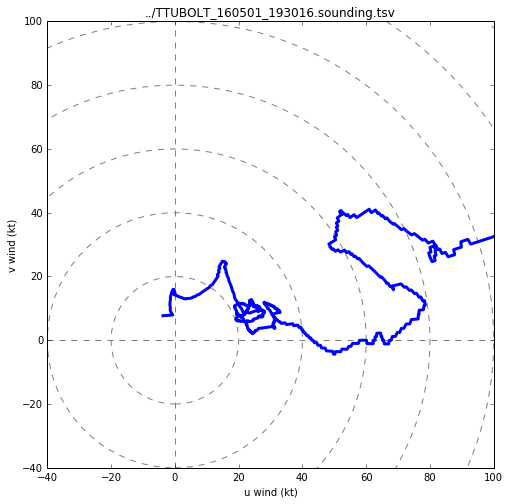

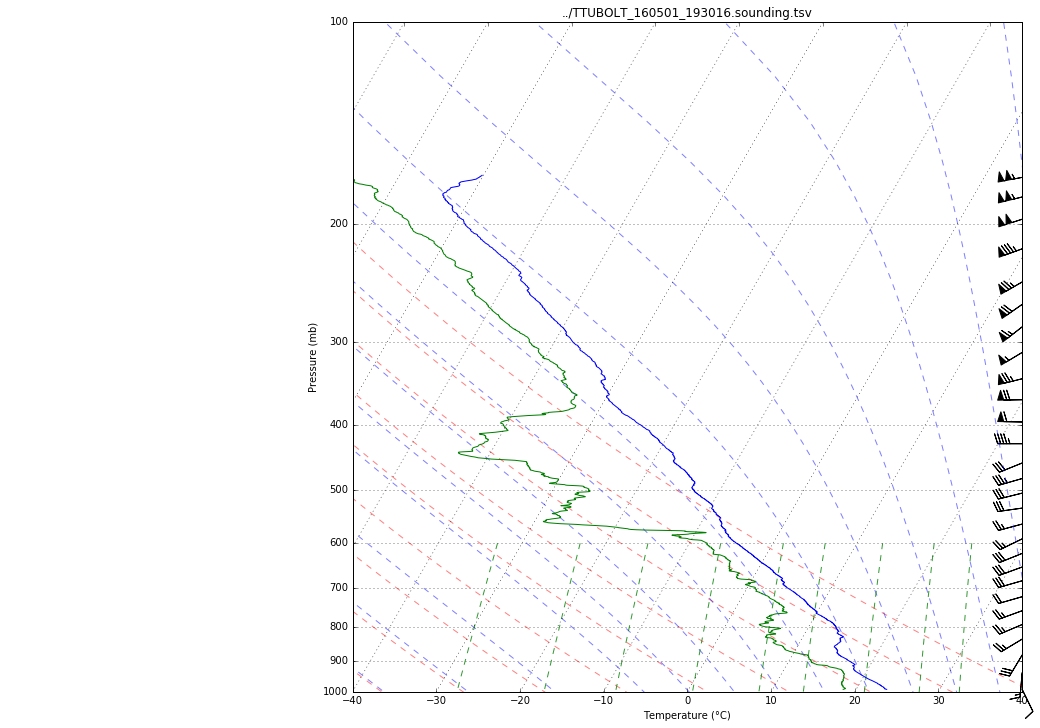

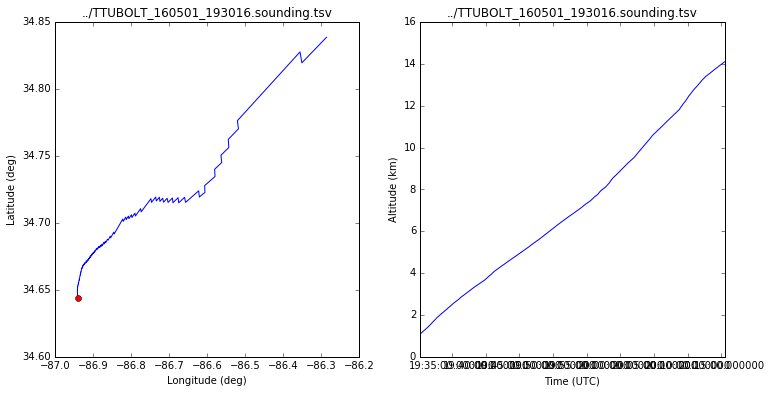

In [29]:
snd = SoundingPostProcessor(may01_19, start_latlon=(34.643958, -86.940602), location="Pyror Field Decatur, AL")
snd.plot_hodo()
snd.plot_skewt()
snd.plot_track()
# snd.print_raw_data(0, 10)
outfile = snd.launch.strftime("%Y%m%d_%H%MZ_TTU_{0}.txt".format(snd.location.replace(" ", "").replace(",", "")))
snd.save_filtered(outfile)

# VORTEX-SE TTU Radiosonde Data
# 2016-05-01, 2030 UTC, Pyror Field Decatur, AL
# latitude (deg), longitude (deg), UTC time from launch (HHMMSS), height (m AGL), pressure (mb), temp (deg C), mixing ratio (g/kg), wind speed (m/s), wind direction (deg)

Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.
Recalculating lat, lon data from az, range data because starting location differs substantially from initial location in data file.


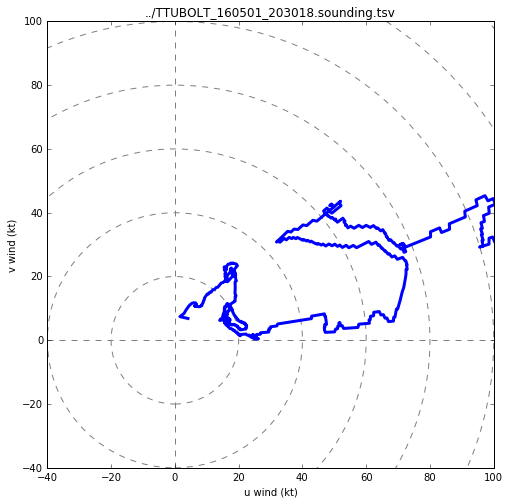

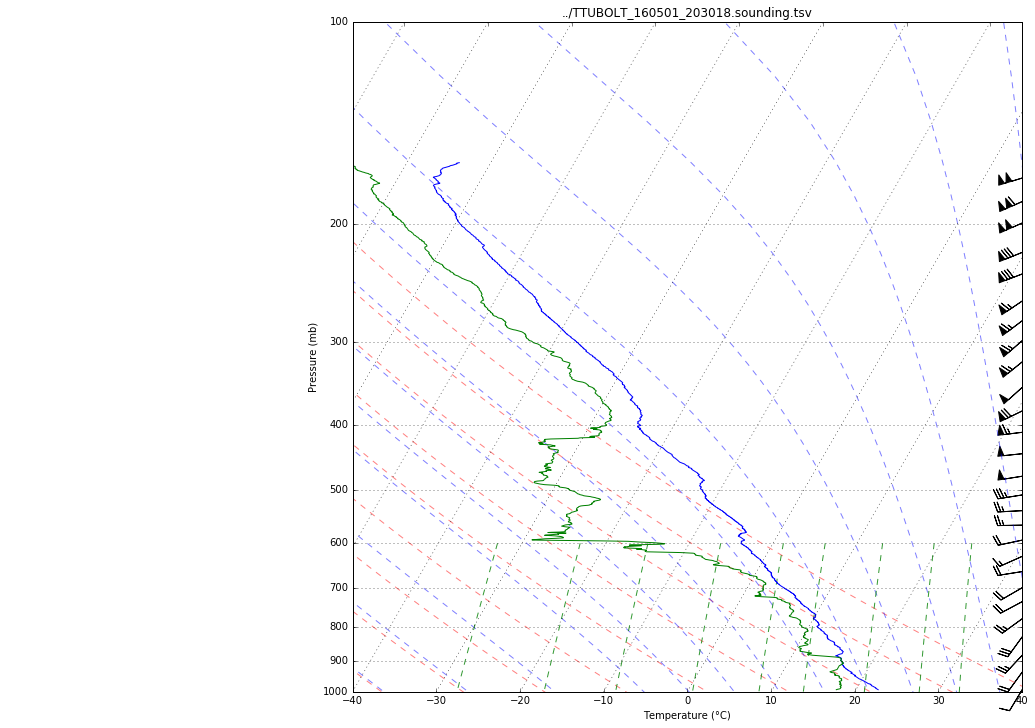

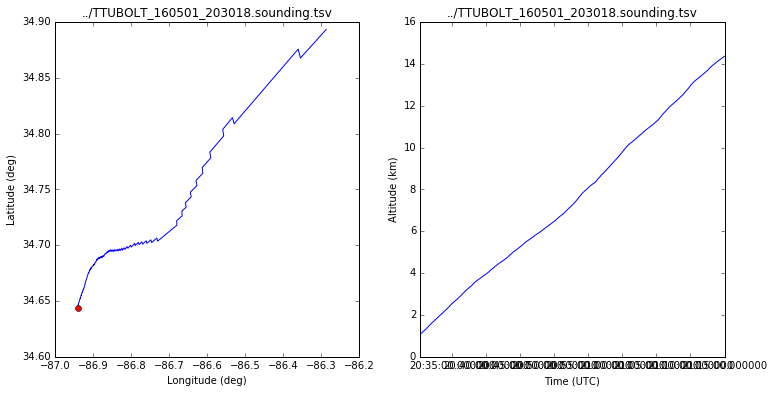

In [30]:
snd = SoundingPostProcessor(may01_20, start_latlon=(34.643958, -86.940602), location="Pyror Field Decatur, AL")
snd.plot_hodo()
snd.plot_skewt()
snd.plot_track()
# snd.print_raw_data(0, 10)
outfile = snd.launch.strftime("%Y%m%d_%H%MZ_TTU_{0}.txt".format(snd.location.replace(" ", "").replace(",", "")))
snd.save_filtered(outfile)